# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

# План работы: 

1. Обзор данных

2. Предобработка данных

3. Добавление нужные столбцы для исследования

4. Исследование основных признаков (найти факторы влияющие на стоимость)

5. Общий вывод

### Откройте файл с данными и изучите общую информацию

Импортируем библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Откроем датасет и выведем первые 5 строк

In [2]:
try:
    df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Выведем общую информацию

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Выведем гистограммы всех признаков

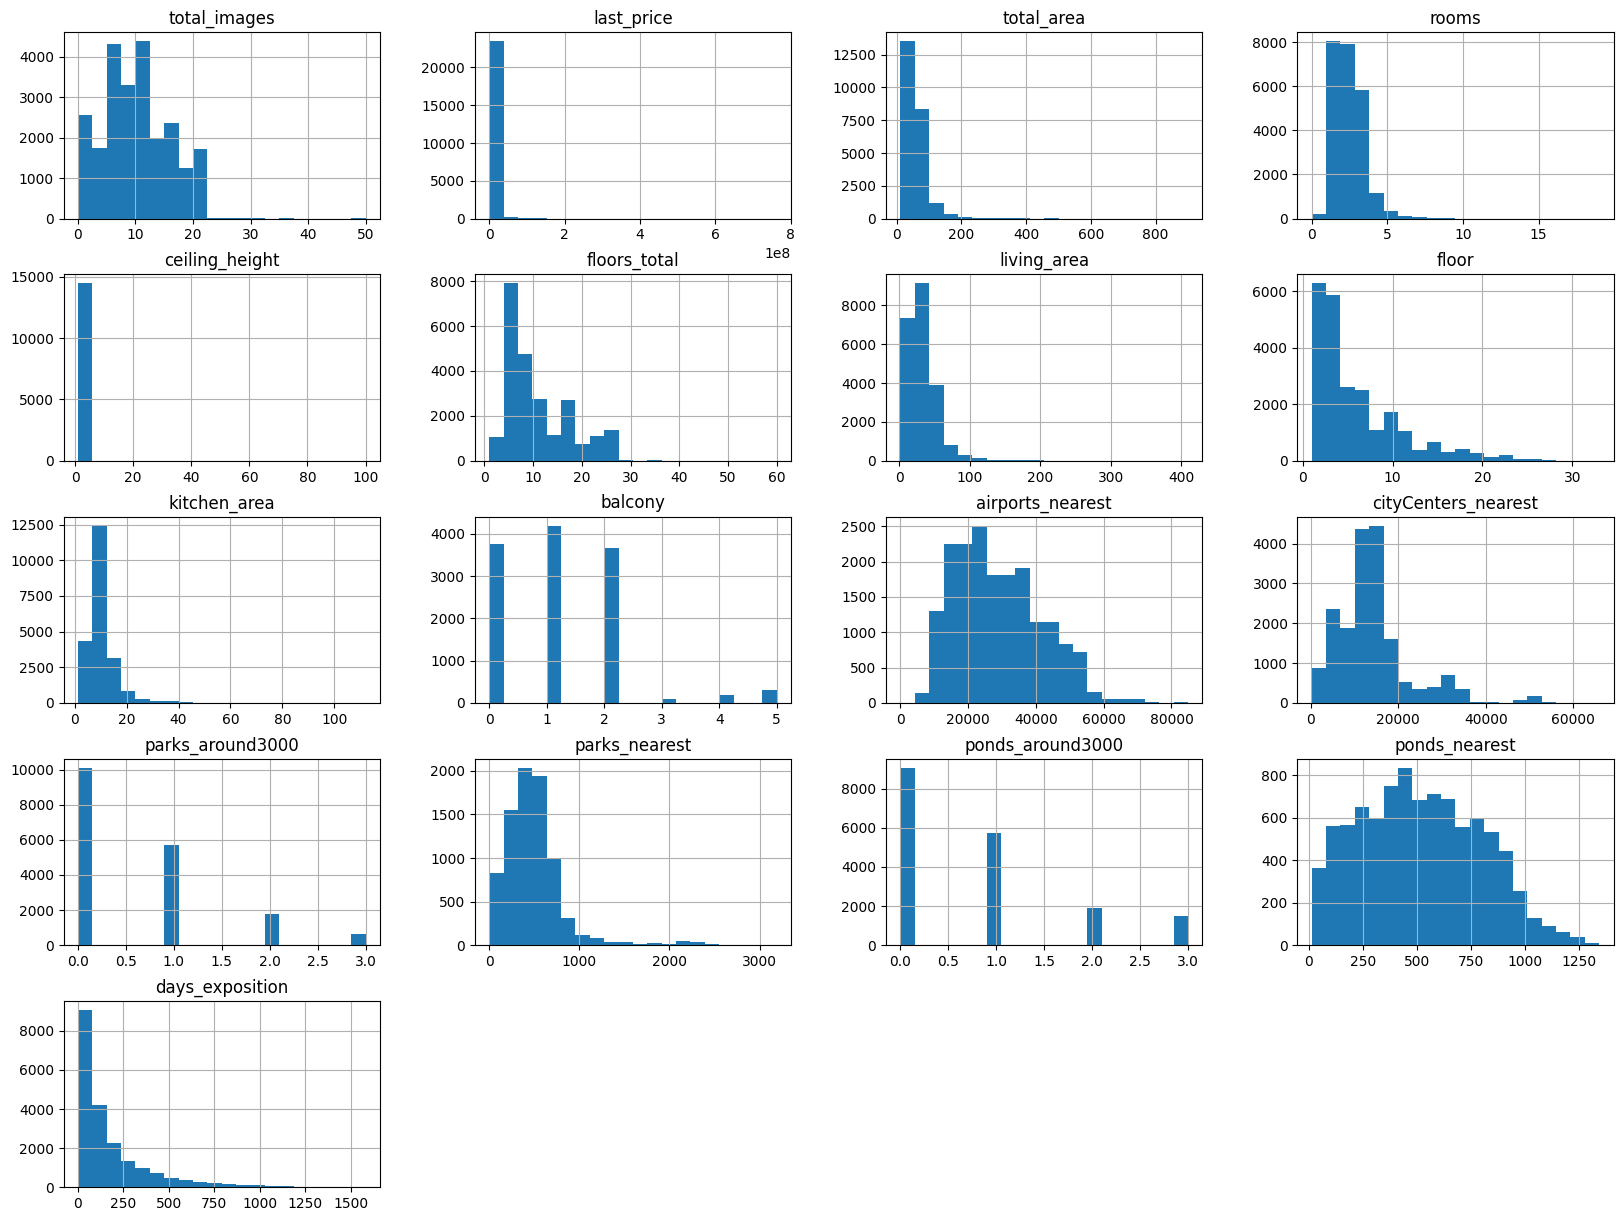

In [4]:
df.hist(bins=20, figsize=(20, 15));

**Вывод:**
В данных имеются пропуски, на некоторых гистограммах видно, что большинство значений скоплено слева, возможно есть выбросы либо справа имеются редкие значения. Всего в датафрейме 23699 объявлений и 22 признака

### Выполните предобработку данных

#### Заполненяем пропуски

In [5]:
df.isna().sum().sort_values(ascending=False)

is_apartment            20924
parks_nearest           15620
ponds_nearest           14589
balcony                 11519
ceiling_height           9195
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
ponds_around3000         5518
days_exposition          3181
kitchen_area             2278
living_area              1903
floors_total               86
locality_name              49
rooms                       0
first_day_exposition        0
total_area                  0
last_price                  0
total_images                0
studio                      0
floor                       0
open_plan                   0
dtype: int64

In [6]:
# check
# пропущенные значения бары

def pass_value_barh(dfg):
    try:
        (
            (dfg.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Количество пропусков для каждого столбца (%)' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

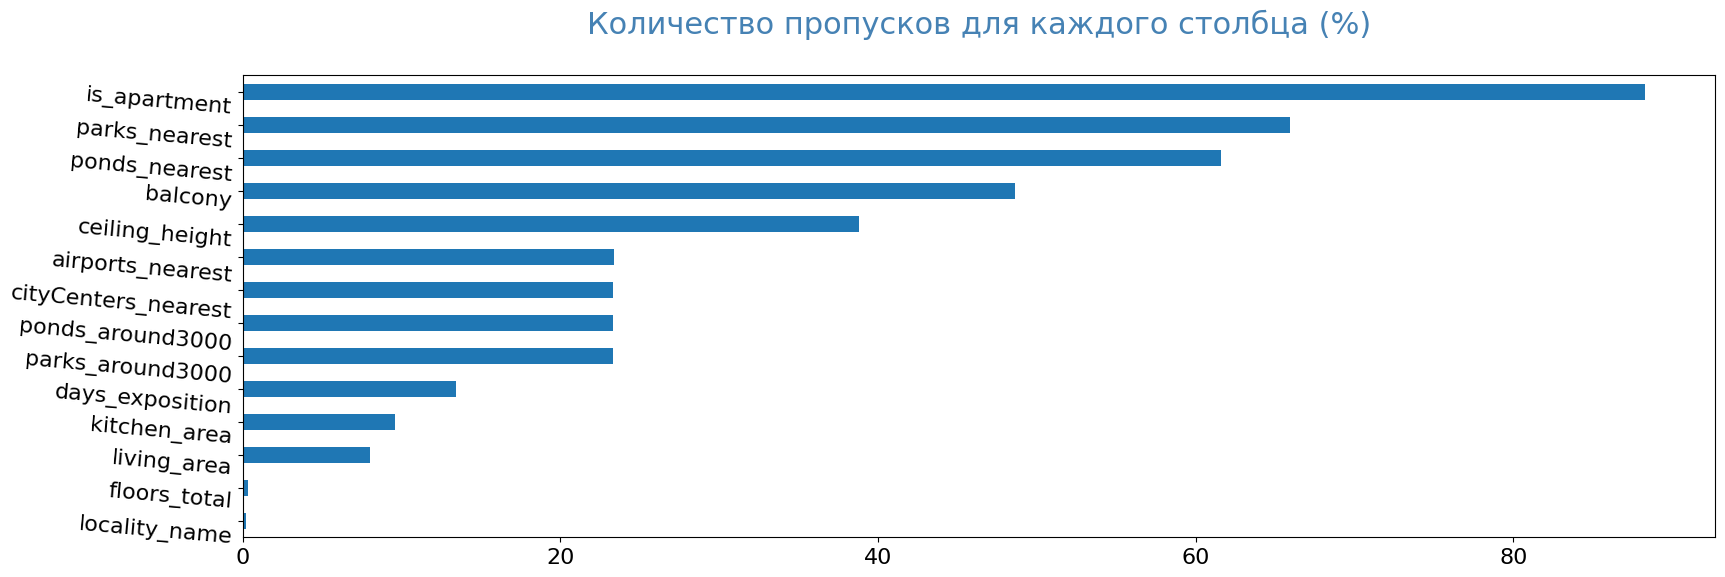

In [7]:
pass_value_barh(df)

In [8]:
df['is_apartment'] = df['is_apartment'].fillna(False)
df['is_apartment'].isna().sum()

C:\Users\99893\AppData\Local\Temp\ipykernel_1484\3566397247.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_apartment'] = df['is_apartment'].fillna(False)


np.int64(0)

In [9]:
df['balcony'] = df['balcony'].fillna(0.0)
df['balcony'].isna().sum()

np.int64(0)

In [10]:
df['ponds_around3000'] = df['ponds_around3000'].fillna(0)
df['parks_around3000'] = df['parks_around3000'].fillna(0)
df[['parks_around3000', 'ponds_around3000']].isna().sum()

parks_around3000    0
ponds_around3000    0
dtype: int64

In [11]:
df['locality_name'].fillna('inknown', inplace=True)
df['locality_name'].isna().sum()

C:\Users\99893\AppData\Local\Temp\ipykernel_1484\3801901706.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['locality_name'].fillna('inknown', inplace=True)


np.int64(0)

In [12]:
df.isna().sum().sort_values(ascending=False)[:2]

parks_nearest    15620
ponds_nearest    14589
dtype: int64

In [13]:
df['ponds_around3000'].value_counts()

ponds_around3000
0.0    14589
1.0     5717
2.0     1892
3.0     1501
Name: count, dtype: int64

In [14]:
df['parks_around3000'].value_counts()

parks_around3000
0.0    15624
1.0     5681
2.0     1747
3.0      647
Name: count, dtype: int64

In [15]:
for name in df['locality_name'].unique():
    df.loc[(df['locality_name'] == name) & \
           (df['ceiling_height'].isna()), 'ceiling_height'] = \
    df.loc[(df['locality_name'] == name) & \
           (df['ceiling_height'] < 5), 'ceiling_height'].mean()

In [16]:
df['ceiling_height'].isna().sum()

np.int64(122)

В некоторых населенных пунктах были только пропуски, поэтому замена не удалась

In [17]:
df['ceiling_height'].fillna(df.query('locality_name != "Санкт-Петербург"')['ceiling_height'].mean(), inplace=True)
df['ceiling_height'].isna().sum()

C:\Users\99893\AppData\Local\Temp\ipykernel_1484\418941292.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ceiling_height'].fillna(df.query('locality_name != "Санкт-Петербург"')['ceiling_height'].mean(), inplace=True)


np.int64(0)

In [18]:
df.dropna(subset=['floors_total'], inplace=True)

Заменим пропуски в столбцах _жилая площадь_ и _площадь кухни_

In [19]:
df['category_area'] = pd.qcut(df['total_area'], q=6)

In [20]:
for category in df['category_area'].unique():
    df.loc[(df['category_area'] == category) & \
           (df['living_area'].isna()), 'living_area'] = \
    df.loc[df['category_area'] == category, 'living_area'].mean()

In [21]:
df['living_area'].isna().sum()

np.int64(0)

In [22]:
for category in df['category_area'].unique():
    df.loc[(df['category_area'] == category) & \
           (df['kitchen_area'].isna()), 'kitchen_area'] = \
    df.loc[df['category_area'] == category, 'kitchen_area'].mean()

In [23]:
df['living_area'].isna().sum()

np.int64(0)

In [24]:
df.isna().sum().sort_values(ascending=False)

parks_nearest           15568
ponds_nearest           14552
airports_nearest         5532
cityCenters_nearest      5509
days_exposition          3172
last_price                  0
total_images                0
floors_total                0
ceiling_height              0
rooms                       0
first_day_exposition        0
total_area                  0
living_area                 0
is_apartment                0
floor                       0
locality_name               0
balcony                     0
kitchen_area                0
open_plan                   0
studio                      0
parks_around3000            0
ponds_around3000            0
category_area               0
dtype: int64

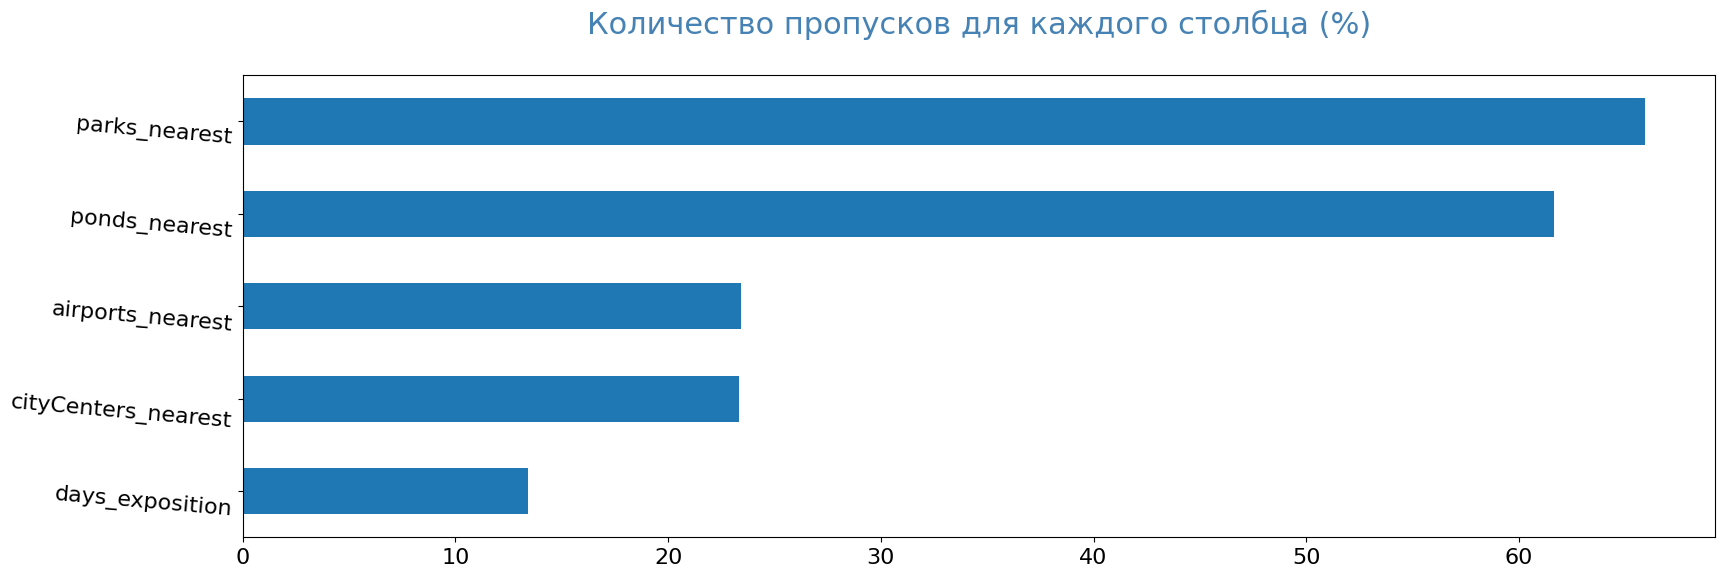

In [25]:
pass_value_barh(df)

#### Изменяем тип данных

In [26]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

columns = ['balcony', 'ponds_around3000', 'parks_around3000', 'floors_total']
for col in columns:
    df[col] = df[col].astype('int')

#### Устраним неявные дубликаты

In [27]:
df['locality_name'] = df['locality_name'] \
    .str.replace('ё', 'е') \
    .replace(['поселок городского типа', 'городской поселок'], 'поселок', regex=True) \
    .replace('коттеджный поселок Лесное', 'поселок Лесное') \
    .replace('деревня Кудрово', 'Кудрово') \
    .where(df['locality_name'] != 'поселок Рябово', 'поселок городского типа Рябово')

In [28]:
df.duplicated(subset=['total_area', 
                      'rooms', 
                      'floor', 
                      'floors_total', 
                      'cityCenters_nearest', 
                      'locality_name']).sum()

np.int64(209)

In [29]:
df.shape[0]

23613

In [30]:
df.drop_duplicates(subset=['total_area', 
                      'rooms', 
                      'floor', 
                      'floors_total', 
                      'cityCenters_nearest', 
                      'locality_name'], inplace=True)

In [31]:
df.shape[0]

23404

#### check name

In [32]:
# check
df.locality_name.nunique()

322

In [33]:
# check
df.locality_name.sort_values().unique()

array(['inknown', 'Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск',
       'Выборг', 'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород',
       'Каменногорск', 'Кингисепп', 'Кириши', 'Кировск', 'Колпино',
       'Коммунар', 'Красное Село', 'Кронштадт', 'Кудрово',
       'Лодейное Поле', 'Ломоносов', 'Луга', 'Любань', 'Мурино',
       'Никольское', 'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф',
       'Пикалево', 'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин',
       'Санкт-Петербург', 'Светогорск', 'Сертолово', 'Сестрорецк',
       'Сланцы', 'Сосновый Бор', 'Сясьстрой', 'Тихвин', 'Тосно',
       'Шлиссельбург', 'деревня Агалатово', 'деревня Аро',
       'деревня Батово', 'деревня Бегуницы', 'деревня Белогорка',
       'деревня Большая Вруда', 'деревня Большая Пустомержа',
       'деревня Большие Колпаны', 'деревня Большое Рейзино',
       'деревня Большой Сабск', 'деревня Бор', 'деревня Борисова Грива',
       'деревня Ваганово', 'деревня Вартемяги', 'деревня Вахнова Кара',
      

**Вывод:**

Пропуски в столбцах с расстояниями до чего либо, связаны с автоматической выгрузкой данных из карт, скорее всего поиск ведется на ограниченном расстоянии от объекта, если в этот диапазон не попал парк, центр города и тд., то скорее всего по этой причине образовались пропуски.

Удаление пропусков:

- Пропуски в столбце `as_apartment` заполнили значение False, если информация не была заполнена значит, можно считать, что это не апартаменты 

- Пропуски в столбце `balcony` заменены значение `0`, если значения не были заполнены, значит, можно сказать, что в таких объектах балконов нет

- Столбцы `ponds_around3000` и `parks_around3000` заполнены значением `0`, пропуски проставила автоматизированная система, так как не нашла парк или пруд в радиусе 3км. Количество пропусков в столбцах ближайший парк и ближайший водоем, зависит от того есть ли парк или водоем в диапазоне 3 км

- Пропуски в столбце `ceiling_height` заполнены средним значением по населенным пунктам

- Пропуски `floors_total` удалены их было всего 86

- Разбили `total_area` на 6 категорий (диапазонов) с помощью метода _qcut_ и заполнили пропуски средним значение `living_area` и `kitchen_area` по соответствующим категориям

- По остальным столбцам с пропусками нет смысла заполнять пропуски, так как возможно искажение оценки например стоимости объекта от других величин, где были заполнены пропуски средним

Изменение типа данных:

- В столбце `first_day_exposition` заменили тип данных с `object` на `datetime`, для дальнейшей работы с датами
- `balcony`, `ponds_around3000`, `parks_around3000`, `floors_total` преобразованы в тип `int`, так как эти признаки определяются целым числом

Устранение дубликотов:
- неявные дубликаты устранены (деревня Кудрово на данный момент является город Кудрово, зафиксировали как "Кудрово")
- 209 явных дубликатов по основным признакам ('total_area', 'rooms', 'floor', 'floors_total', 'cityCenters_nearest', 'locality_name')

### Добавьте в таблицу новые столбцы

Добавим столбцы:
- Цена за один квадратный метр
- День публикации объявления
- Месяц публикации объявления
- Год побликации объявления
- Столбец категории этажа
- Расстояние до центра города в км

In [34]:
df['one_square_m_price'] = (df['last_price'] / df['total_area']).round(2)
df['first_weekday_exposition'] = df['first_day_exposition'].dt.weekday
df['first_month_exposition'] = df['first_day_exposition'].dt.month
df['first_year_exposition'] = df['first_day_exposition'].dt.year

In [35]:
def categorize_floor(row):
    floor = row['floor']
    floors_total = row['floors_total']
    try:
        if floor == 1:
            return 'первый'
        elif floor == floors_total:
            return 'последний'
        elif 1 < floor < floors_total:
            return 'другой'
        else:
            return 'Неизветсный этаж!'
    except:
        print('Ошибка в данных, этаж не считался!')

In [36]:
df['categorize_floor'] = df.apply(categorize_floor, axis=1)

In [37]:
df['city_centers_nearest_km'] = df['cityCenters_nearest'].apply(lambda x: round(x / 1000, 0))

In [38]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,category_area,one_square_m_price,first_weekday_exposition,first_month_exposition,first_year_exposition,categorize_floor,city_centers_nearest_km
0,20,13000000.0,108.0,2019-03-07,3,2.700000,16,51.000000,8,False,...,2,755.0,NaN,"(79.6, 900.0]",120370.37,3,3,2019,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,2.644470,11,18.600000,1,False,...,0,NaN,81.0,"(36.0, 43.6]",82920.79,1,12,2018,первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,2.762032,5,34.300000,4,False,...,2,574.0,558.0,"(52.0, 62.0]",92785.71,3,8,2015,другой,14.0
3,0,64900000.0,159.0,2015-07-24,3,2.762032,14,67.400678,9,False,...,3,234.0,424.0,"(79.6, 900.0]",408176.10,4,7,2015,другой,7.0
4,2,10000000.0,100.0,2018-06-19,2,3.030000,14,32.000000,13,False,...,1,48.0,121.0,"(79.6, 900.0]",100000.00,1,6,2018,другой,8.0


### Проведите исследовательский анализ данных

#### Изучим некоторые столбцы датафрейма

In [39]:
df[['total_area', 
    'living_area', 
    'kitchen_area', 
    'last_price', 
    'rooms', 
    'ceiling_height', 
    'categorize_floor', 
    'floors_total', 
    'cityCenters_nearest', 
    'parks_nearest']].describe()

,total_area,living_area,kitchen_area,last_price,rooms,ceiling_height,floors_total,cityCenters_nearest,parks_nearest
count,23404.000000,23404.000000,23404.000000,2.340400e+04,23404.000000,23404.000000,23404.000000,18043.000000,8021.000000
mean,60.390871,34.542550,10.535138,6.555580e+06,2.072253,2.751776,10.701376,14187.859724,490.402568
std,35.687007,21.715413,5.713609,1.092883e+07,1.079675,0.993814,6.600956,8615.189096,340.748891
min,12.000000,2.000000,1.300000,1.219000e+04,0.000000,1.000000,1.000000,181.000000,1.000000
25%,40.000000,19.000000,7.400000,3.450000e+06,1.000000,2.600000,5.000000,9236.000000,288.000000
50%,52.000000,30.000000,9.151527,4.650000e+06,2.000000,2.700000,9.000000,13094.000000,455.000000
75%,70.000000,42.000000,11.800000,6.800000e+06,3.000000,2.762032,16.000000,16285.000000,612.000000
max,900.000000,409.700000,112.000000,7.630000e+08,19.000000,100.000000,60.000000,65968.000000,3190.000000


Изучим общую площадь

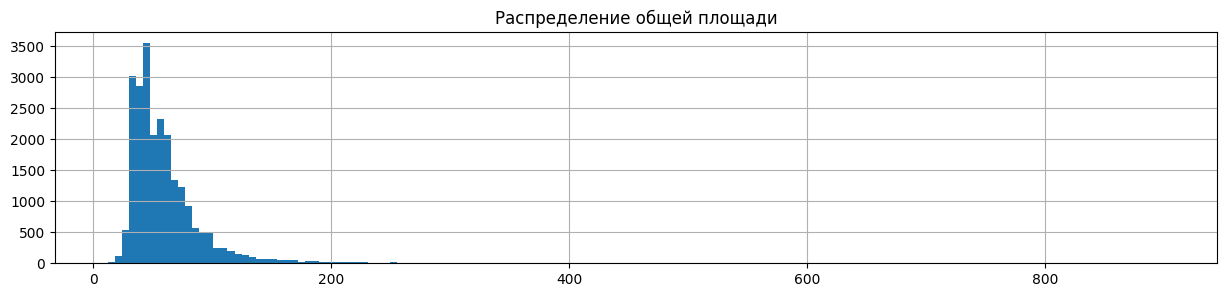

In [40]:
df['total_area'].hist(bins=150, figsize=(15,3))
plt.title('Распределение общей площади');

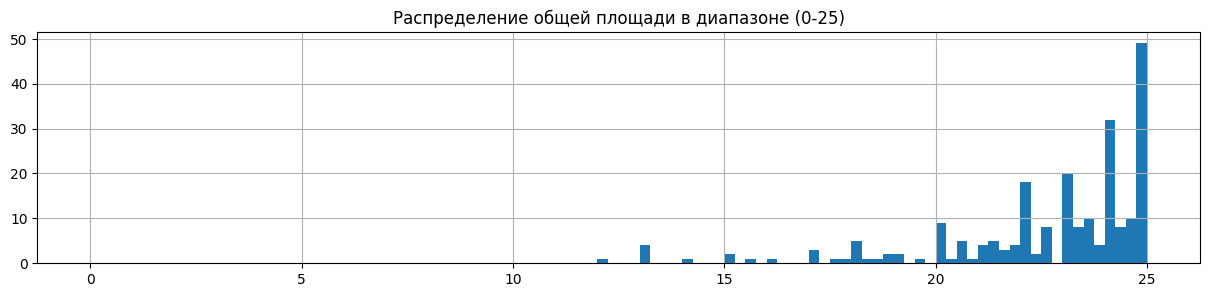

In [41]:
df['total_area'].hist(bins=100, figsize=(15,3), range=(0,25))
plt.title('Распределение общей площади в диапазоне (0-25)');

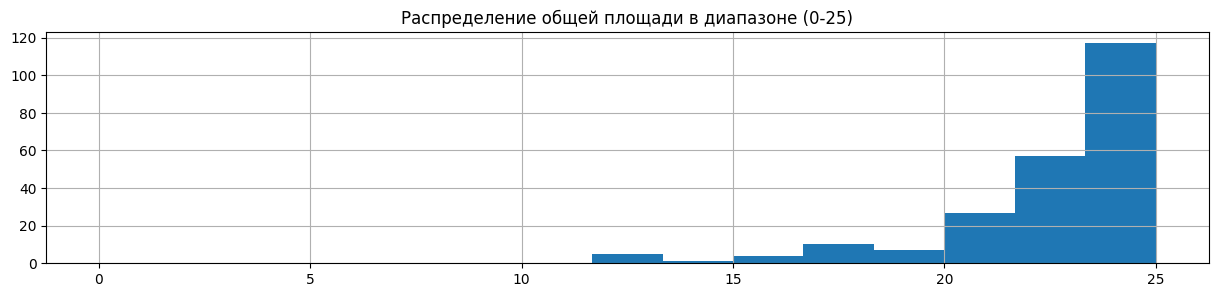

In [42]:
df['total_area'].hist(bins=15, figsize=(15,3), range=(0,25))
plt.title('Распределение общей площади в диапазоне (0-25)');

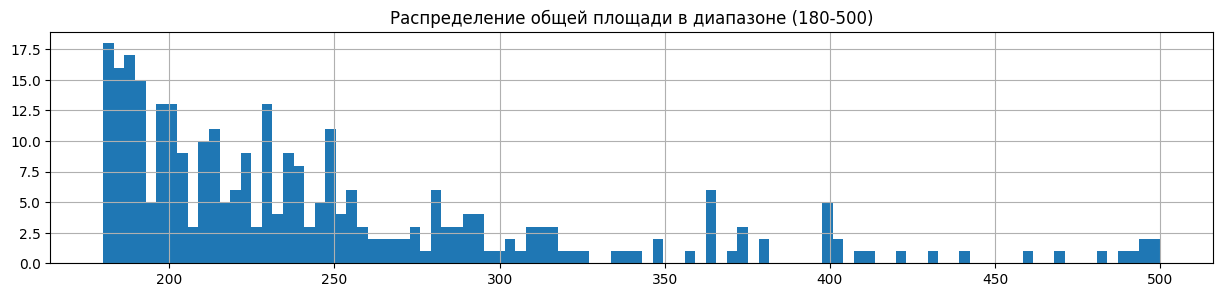

In [43]:
df['total_area'].hist(bins=100, figsize=(15,3), range=(180, 500))
plt.title('Распределение общей площади в диапазоне (180-500)');

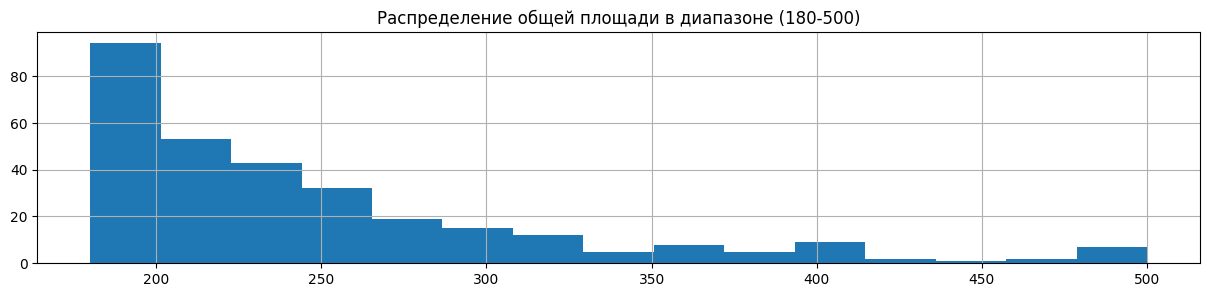

In [44]:
df['total_area'].hist(bins=15, figsize=(15,3), range=(180, 500))
plt.title('Распределение общей площади в диапазоне (180-500)');

Удалим хвосты все, что до 20, и все что после 250

In [45]:
good_df = df.query('20 < total_area < 250')

In [46]:
good_df.shape[0] / df.shape[0]

0.9936335669116391

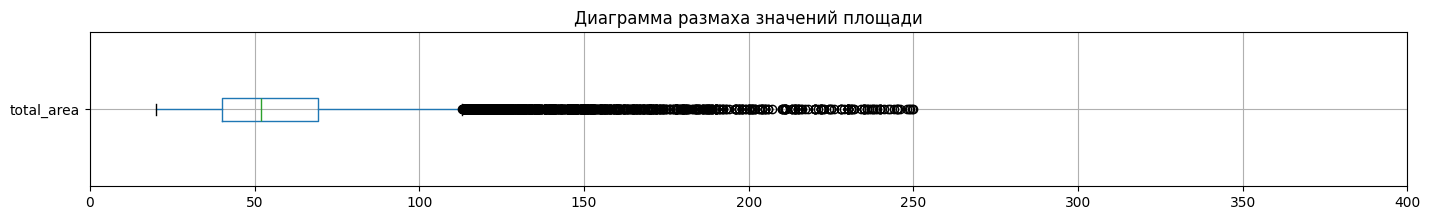

In [47]:
# check
# для примера горизонтальный вид диаграммы размаха

fig, ax = plt.subplots(figsize = (17,2))
ax = good_df[['total_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений площади')
ax.set_xlim(0, 400);

Основное распределение лежит в диапазоне от 20 до 250, все остальное, пик находится примерно в диапазоне 45-60

Изучим жилую площадь

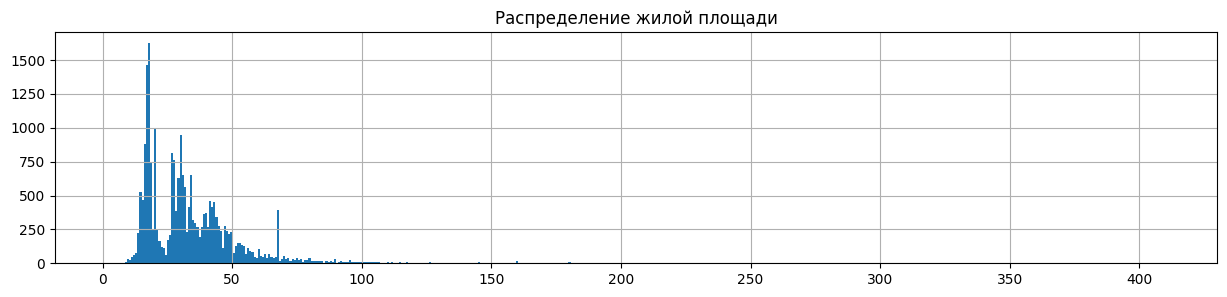

In [48]:
df['living_area'].hist(bins=500, figsize=(15,3))
plt.title('Распределение жилой площади');

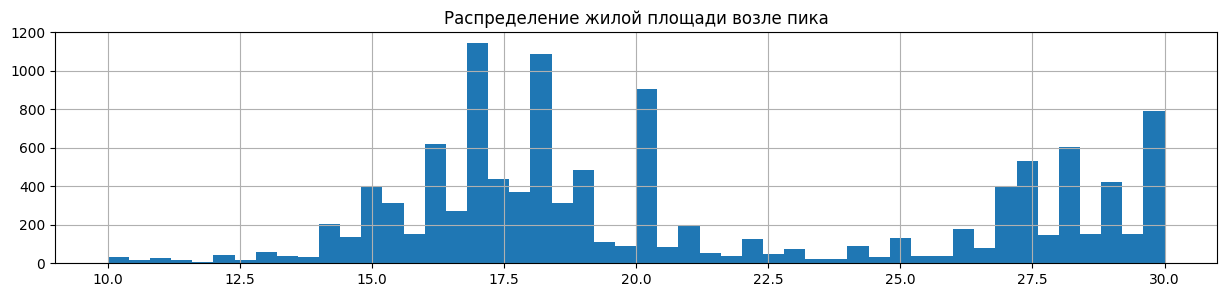

In [49]:
df['living_area'].hist(bins=50, figsize=(15,3), range=(10, 30))
plt.title('Распределение жилой площади возле пика');

В диапазоне от 20 до 30 наблюдается провал

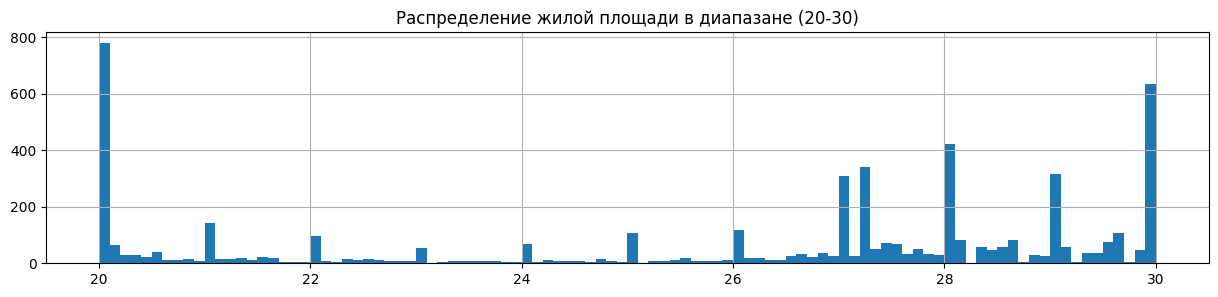

In [50]:
df['living_area'].hist(bins=100, figsize=(15,3), range=(20, 30))
plt.title('Распределение жилой площади в диапазане (20-30)');

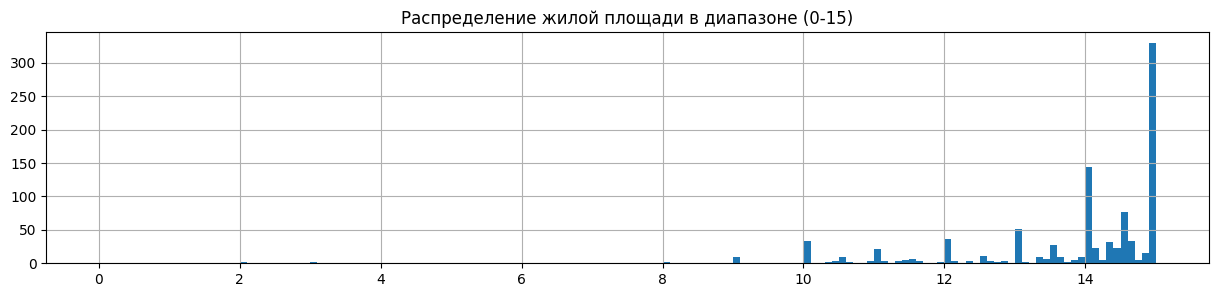

In [51]:
df['living_area'].hist(bins=150, figsize=(15,3), range=(0, 15))
plt.title('Распределение жилой площади в диапазоне (0-15)');

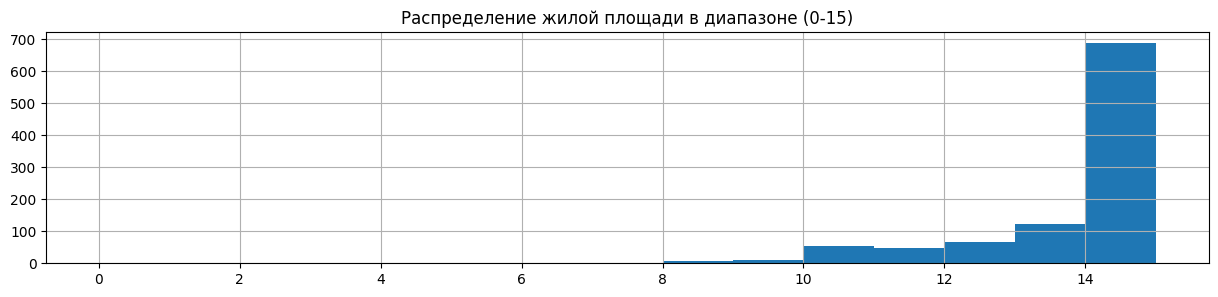

In [52]:
df['living_area'].hist(bins=15, figsize=(15,3), range=(0, 15))
plt.title('Распределение жилой площади в диапазоне (0-15)');

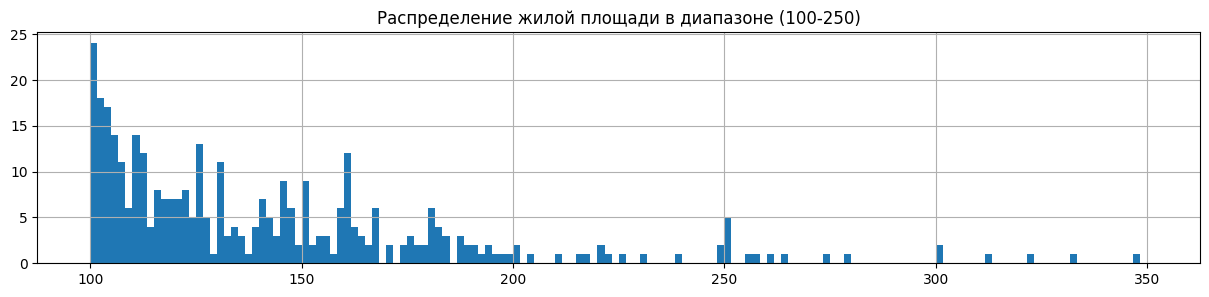

In [53]:
df['living_area'].hist(bins=150, figsize=(15,3), range=(100, 350))
plt.title('Распределение жилой площади в диапазоне (100-250)');

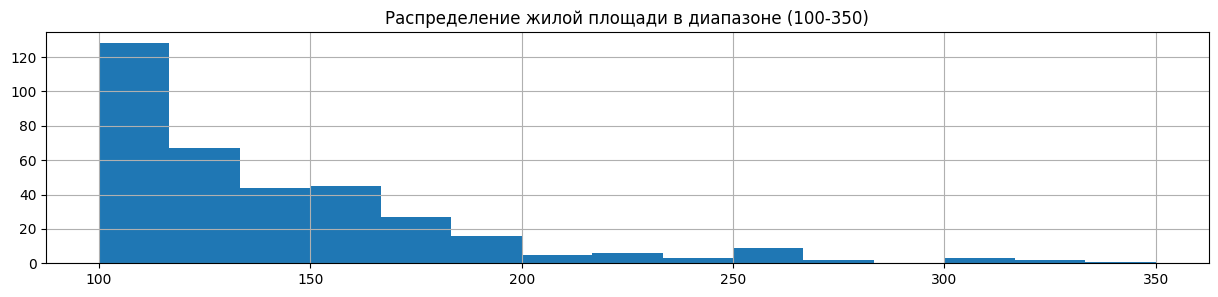

In [54]:
df['living_area'].hist(bins=15, figsize=(15,3), range=(100, 350))
plt.title('Распределение жилой площади в диапазоне (100-350)');

Избавимся от значений меньше 12 и больше 125

In [55]:
100 - good_df.query('12 <= living_area <= 125').shape[0] / good_df.shape[0] * 100

1.0019350677273735

In [56]:
good_df = good_df.query('12 <= living_area <= 125')

Пиковое значение находится примерно в диапазоне от 17 до 20, дальше идет резкий провал в диапазоне от 21 до 26, снова пик, но меньше примерно в 2 раза, дальше идет уменьшение с длинным хвостом. Значения меньше 12 и больше 125 удалены

Изучим площадь кухонь

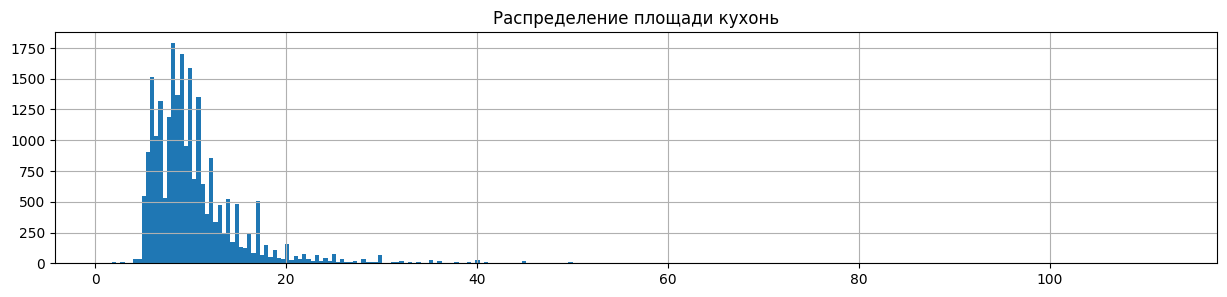

In [57]:
df['kitchen_area'].hist(bins=250, figsize=(15,3))
plt.title('Распределение площади кухонь');

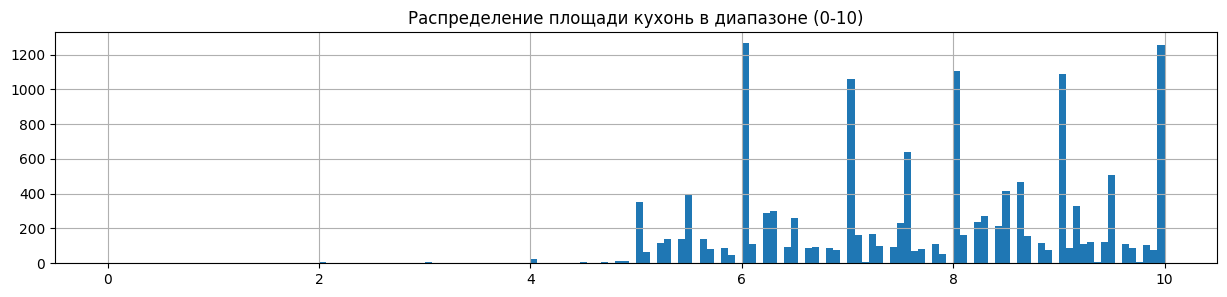

In [58]:
df['kitchen_area'].hist(bins=150, figsize=(15,3), range=(0, 10))
plt.title('Распределение площади кухонь в диапазоне (0-10)');

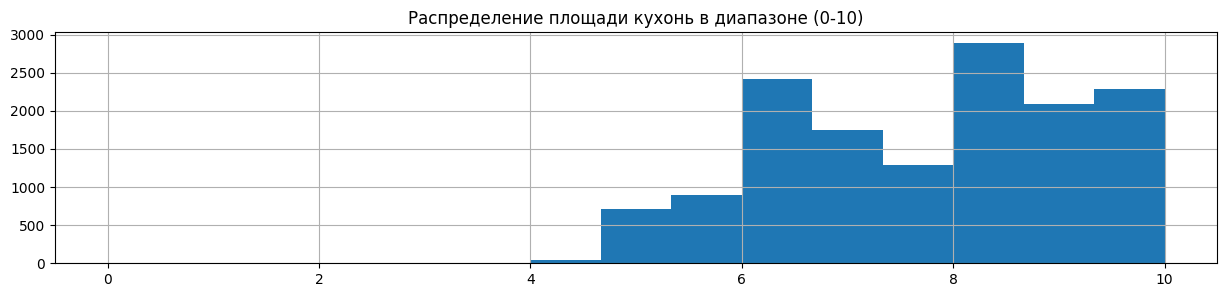

In [59]:
df['kitchen_area'].hist(bins=15, figsize=(15,3), range=(0, 10))
plt.title('Распределение площади кухонь в диапазоне (0-10)');

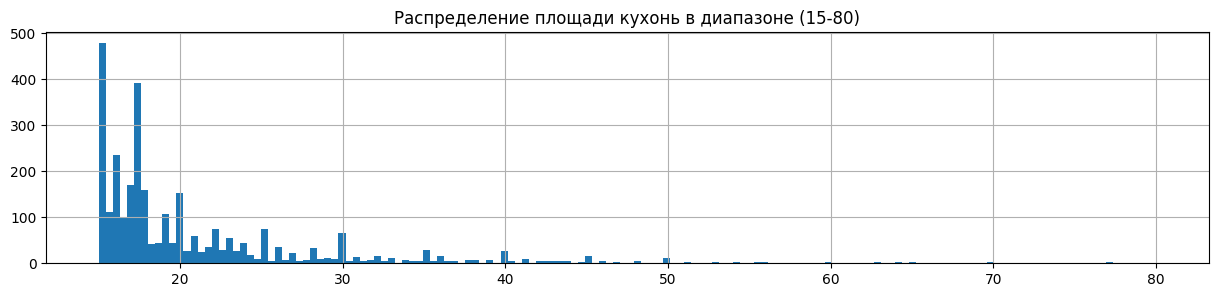

In [60]:
df['kitchen_area'].hist(bins=150, figsize=(15,3), range=(15, 80))
plt.title('Распределение площади кухонь в диапазоне (15-80)');

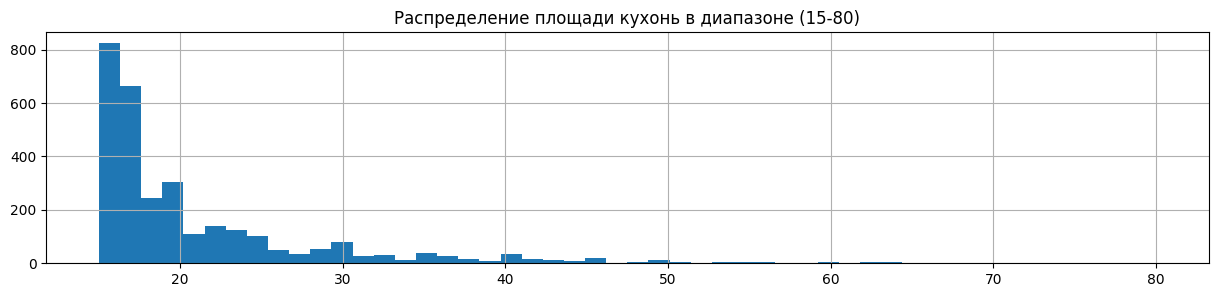

In [61]:
df['kitchen_area'].hist(bins=50, figsize=(15,3), range=(15, 80))
plt.title('Распределение площади кухонь в диапазоне (15-80)');

Удалим хвосты - значения меньше 4 и больше 40

In [62]:
100 - good_df.query('4 < kitchen_area < 40').shape[0] / good_df.shape[0] * 100

0.7123620884371462

In [63]:
good_df = good_df.query('4 < kitchen_area < 40')

Пик находится примерно в диапазоне от 5 до 17. Все значения меньше 4 и больше 40 удалены, так как эти значения очень редкие. Большинство кухонь укладывается в диапазон 5-20 кв.м

Изучим цену квартир

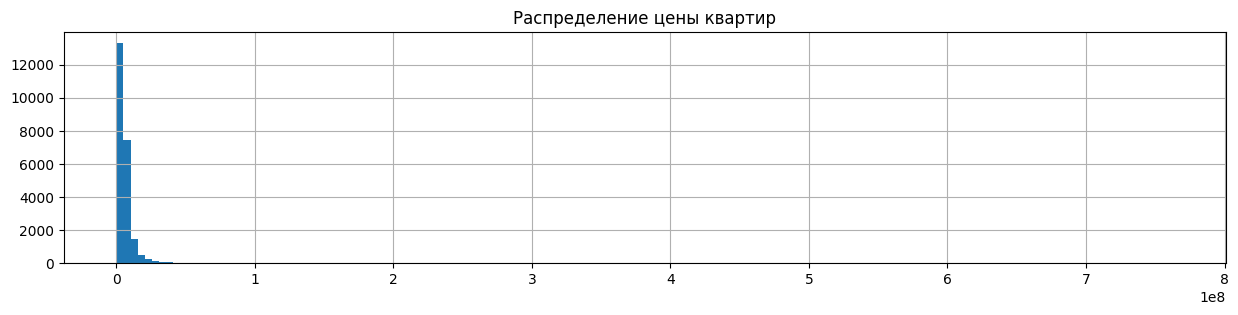

In [64]:
df['last_price'].hist(bins=150, figsize=(15,3))
plt.title('Распределение цены квартир');

In [65]:
good_df['last_price'].describe()

count    2.285800e+04
mean     5.950420e+06
std      5.605175e+06
min      4.300000e+05
25%      3.450000e+06
50%      4.600000e+06
75%      6.690000e+06
max      2.892384e+08
Name: last_price, dtype: float64

Рассмотрим пик

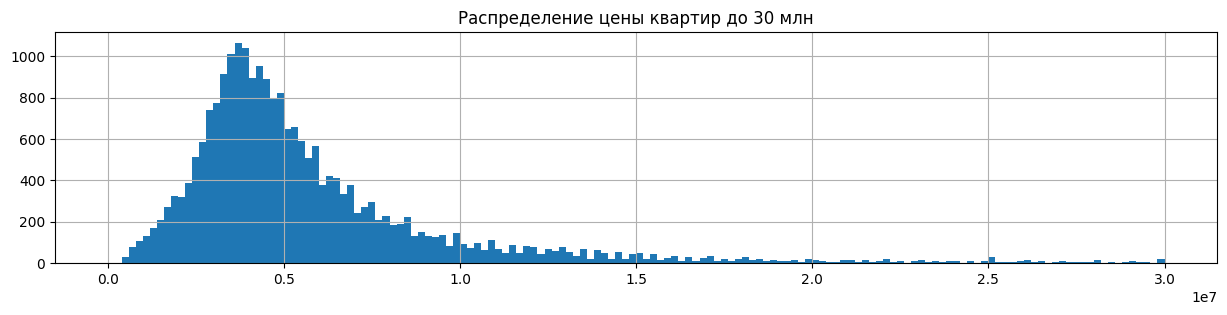

In [66]:
df['last_price'].hist(bins=150, figsize=(15,3), range=(0, 30_000_000))
plt.title('Распределение цены квартир до 30 млн');

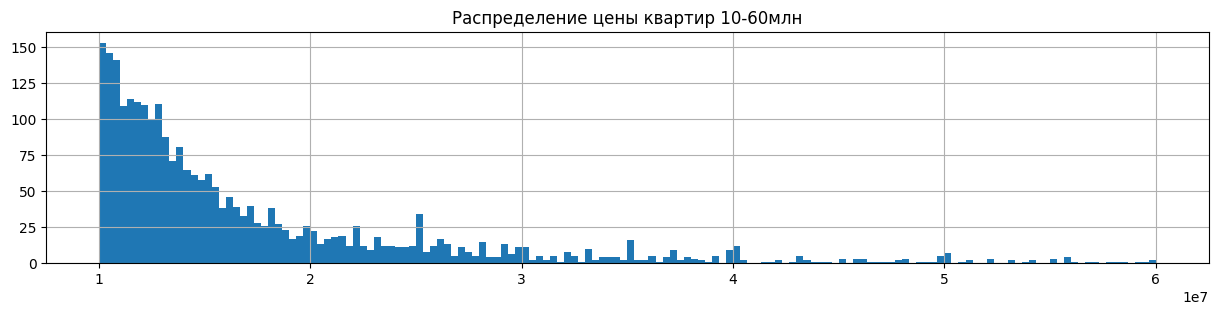

In [67]:
df['last_price'].hist(bins=150, figsize=(15,3), range=(10_000_000, 60_000_000))
plt.title('Распределение цены квартир 10-60млн');

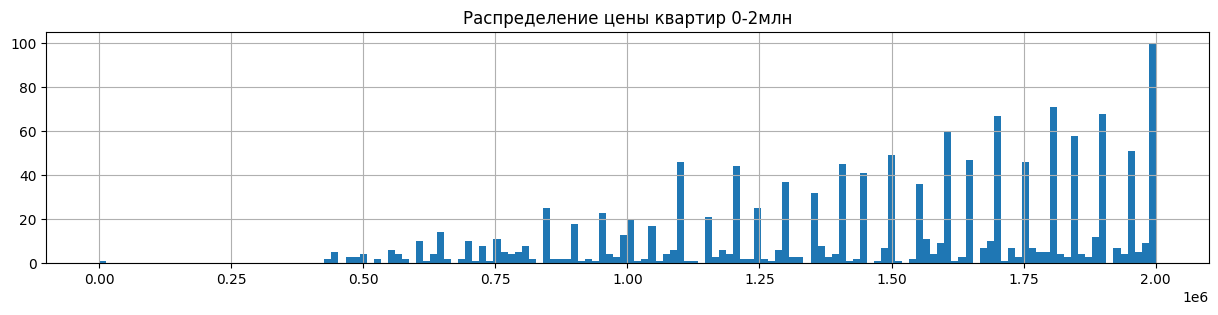

In [68]:
df['last_price'].hist(bins=150, figsize=(15,3), range=(0, 2_000_000))
plt.title('Распределение цены квартир 0-2млн');

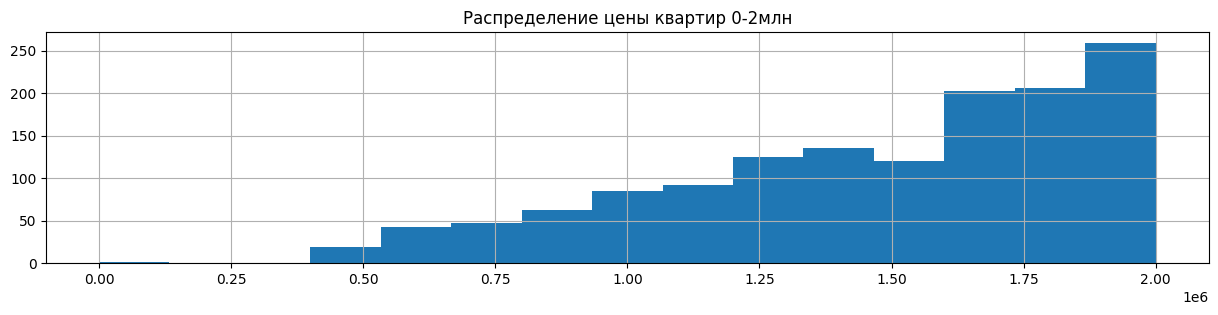

In [69]:
df['last_price'].hist(bins=15, figsize=(15,3), range=(0, 2_000_000))
plt.title('Распределение цены квартир 0-2млн');

In [70]:
100 - good_df.query('1_000_000 < last_price < 40_000_000').shape[0] / good_df.shape[0] * 100

1.3518243065884974

In [71]:
dood_df = good_df.query('1_000_000 < last_price < 40_000_000')

Основное распределение в диапазоне от 1 до 40млн, по обе стороны хвосты, которые были удалены. Пик значений примерно в диапазоне от 2.5 до 5млн

Изучим количество комнат

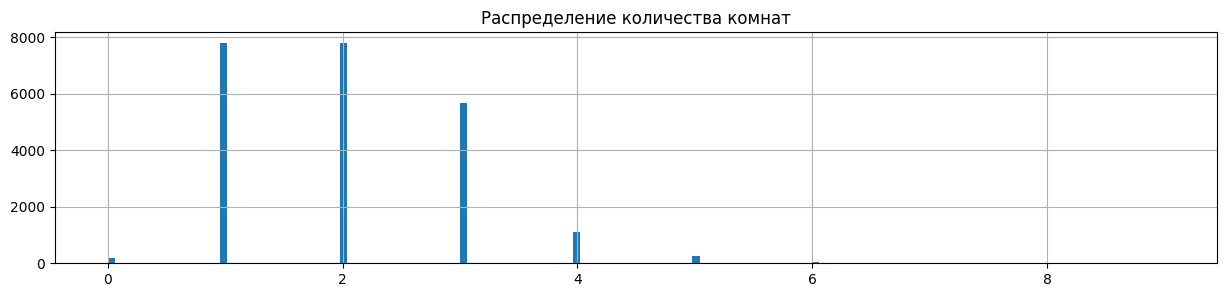

In [72]:
good_df['rooms'].hist(bins=150, figsize=(15, 3))
plt.title('Распределение количества комнат');

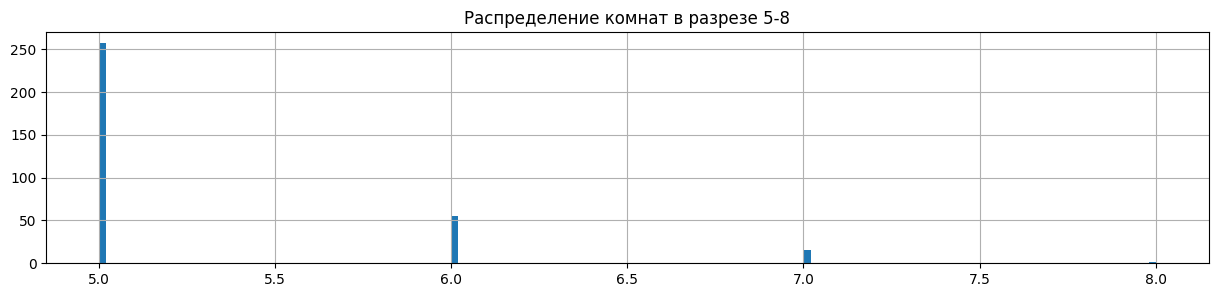

In [73]:
good_df['rooms'].hist(bins=150, figsize=(15, 3), range=(5, 8))
plt.title('Распределение комнат в разрезе 5-8');

In [74]:
100 - good_df.query('1 <= rooms <= 5').shape[0] / good_df.shape[0] * 100

1.1068334937439914

In [75]:
good_df = good_df.query('1 <= rooms <= 5')

Типовое количество комнат 1, 2, 3. Больше 5 комнат будем считать редкостями

Изучим высоту потолков

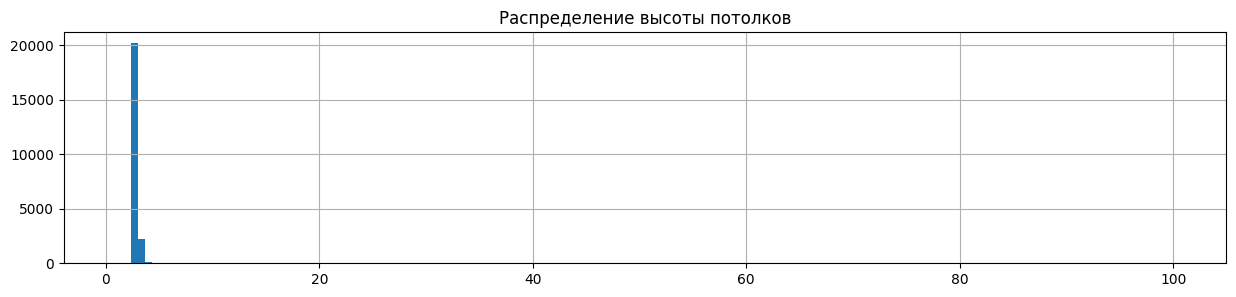

In [76]:
good_df['ceiling_height'].hist(bins=150, figsize=(15, 3))
plt.title('Распределение высоты потолков');

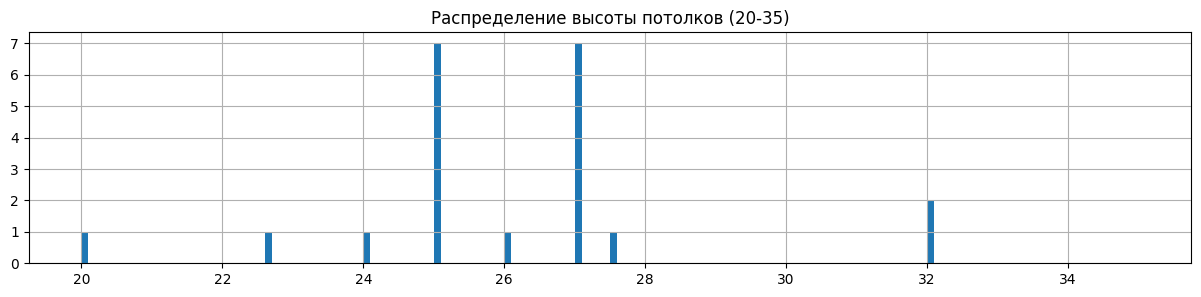

In [77]:
good_df['ceiling_height'].hist(bins=150, figsize=(15, 3), range=(20, 35))
plt.title('Распределение высоты потолков (20-35)');

Поделим на 10 значения 25, 27, 32, так как они могу являться ошибкой ввода

In [78]:
good_df['ceiling_height'] = good_df['ceiling_height'].apply(lambda x: x / 10 if x == 25 or x == 27 or x == 32 else x)

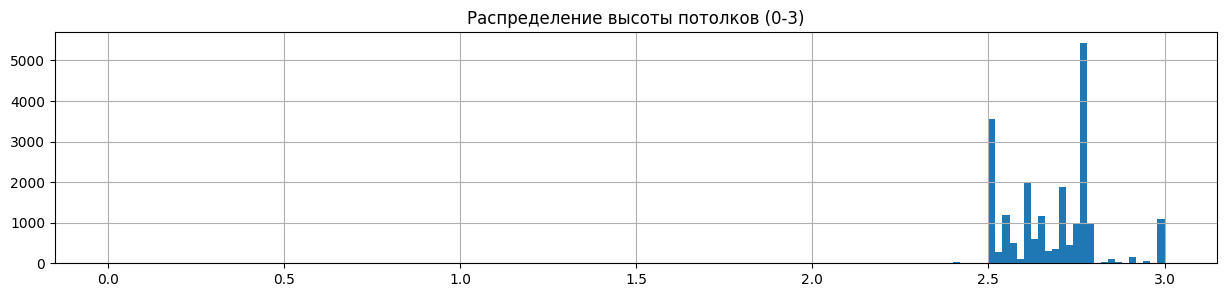

In [79]:
good_df['ceiling_height'].hist(bins=150, figsize=(15, 3), range=(0, 3))
plt.title('Распределение высоты потолков (0-3)');

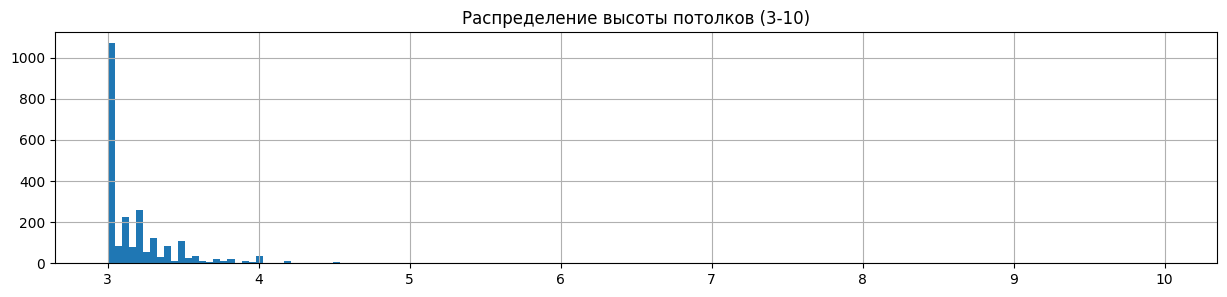

In [80]:
good_df['ceiling_height'].hist(bins=150, figsize=(15, 3), range=(3, 10))
plt.title('Распределение высоты потолков (3-10)');

In [81]:
100 - good_df.query('2.5 <= ceiling_height <= 4').shape[0] / good_df.shape[0] * 100

0.5175846051758413

In [82]:
good_df = good_df.query('2.5 <= ceiling_height <= 4')

Основное распределение находится в диапазоне от 2.5 до 4 м. Остальное считаем редкостями и удалим

Изучим тип этажа

<Axes: >

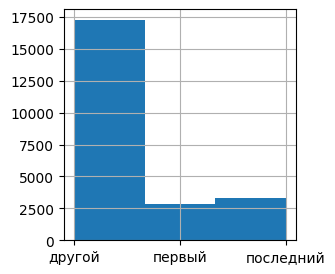

In [83]:
df['categorize_floor'].hist(bins=3, figsize=(3, 3))

Большинство квартир находится между первым и последним этажем

Изучим этажность объекта в котором находится квартира

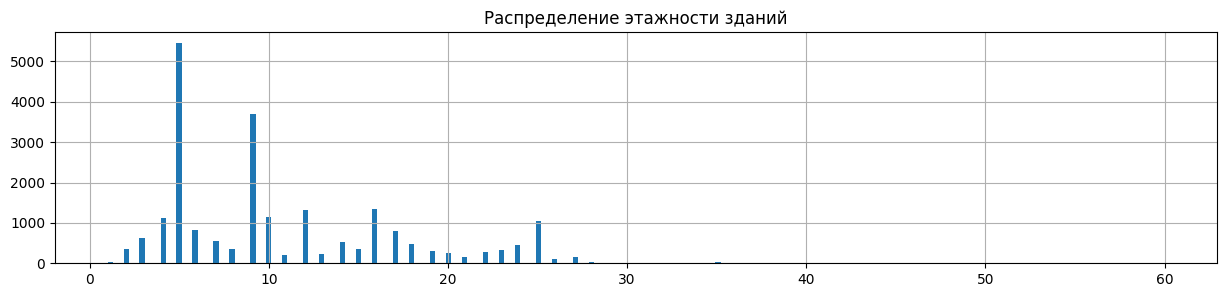

In [84]:
good_df['floors_total'].hist(bins=200, figsize=(15, 3))
plt.title('Распределение этажности зданий');

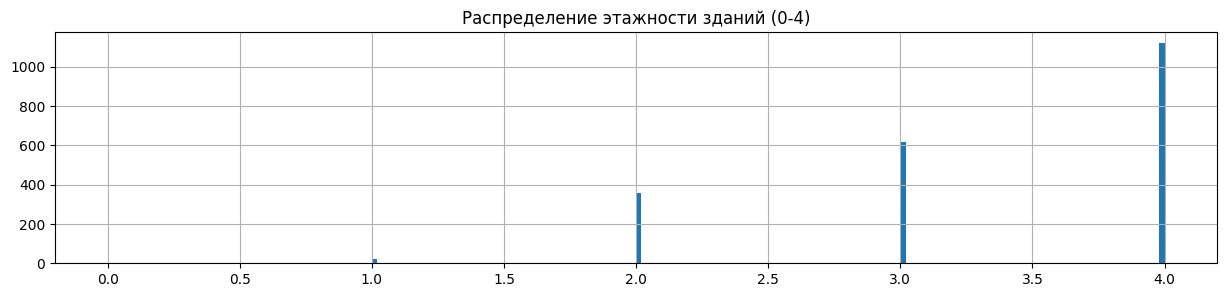

In [85]:
good_df['floors_total'].hist(bins=200, figsize=(15, 3), range=(0, 4))
plt.title('Распределение этажности зданий (0-4)');

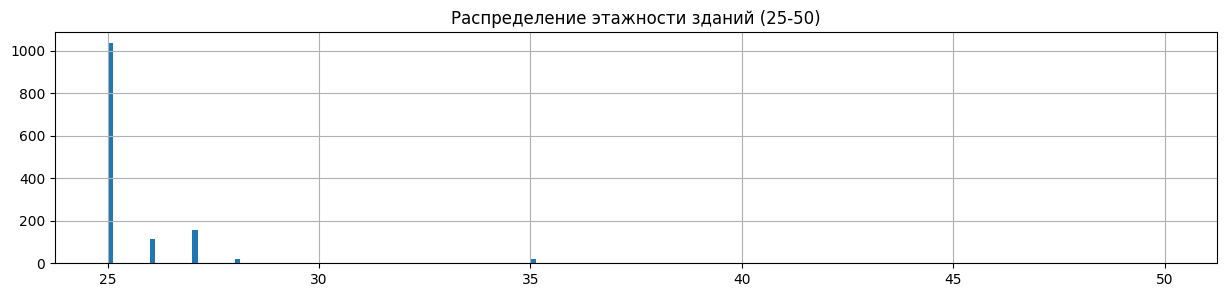

In [86]:
good_df['floors_total'].hist(bins=200, figsize=(15, 3), range=(25, 50))
plt.title('Распределение этажности зданий (25-50)');

In [87]:
100 - good_df.query('2 <= floors_total < 30').shape[0] / good_df.shape[0] * 100

0.22234080398433775

In [88]:
good_df = good_df.query('2 <= floors_total < 30')

Типовая этажность - 5 этажей и 9 этажей. Значения меньше 2 и больше 30 считаем редкостями

Изучим расстояние до центра города

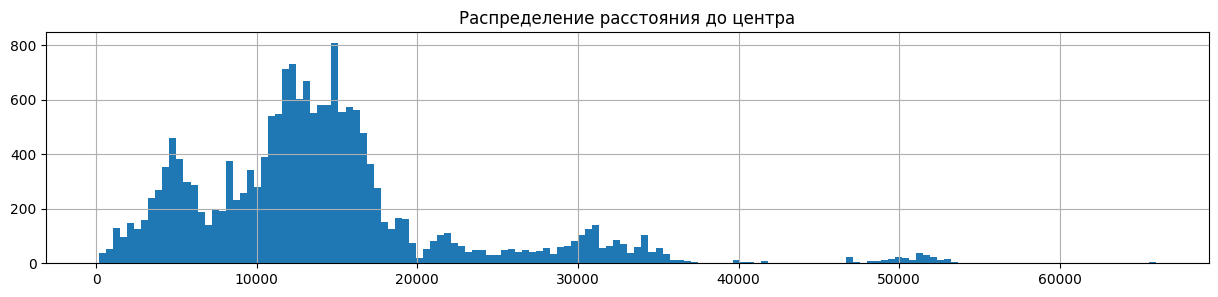

In [89]:
df['cityCenters_nearest'].hist(bins=150, figsize=(15, 3), )
plt.title('Распределение расстояния до центра');

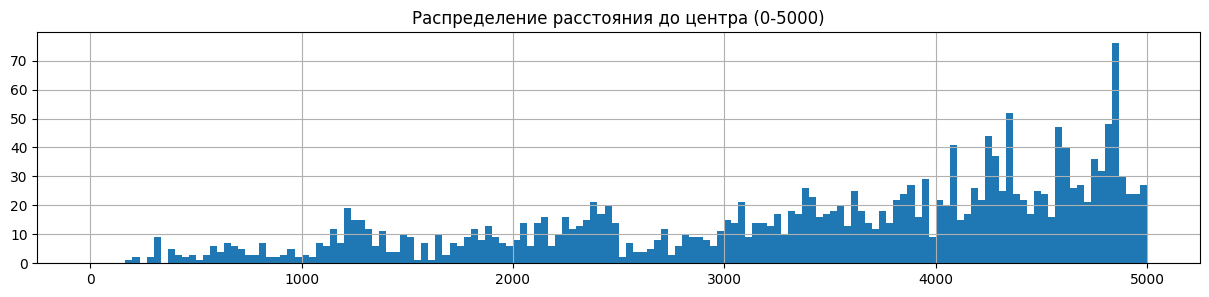

In [90]:
df['cityCenters_nearest'].hist(bins=150, figsize=(15, 3), range=(0, 5000))
plt.title('Распределение расстояния до центра (0-5000)');

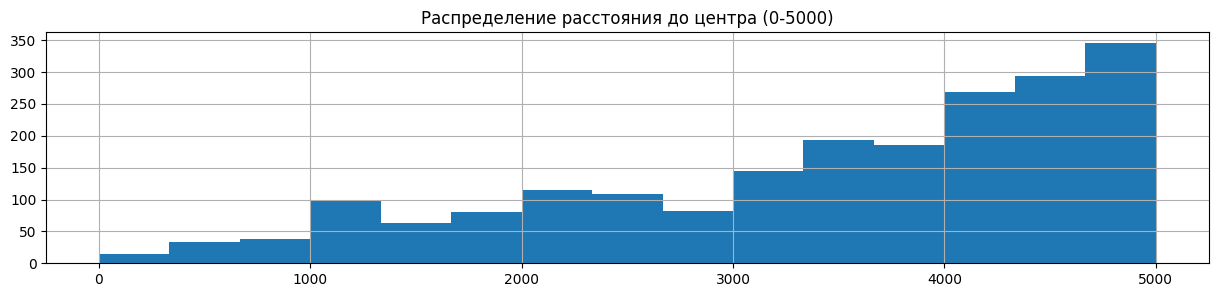

In [91]:
df['cityCenters_nearest'].hist(bins=15, figsize=(15, 3), range=(0, 5000))
plt.title('Распределение расстояния до центра (0-5000)');

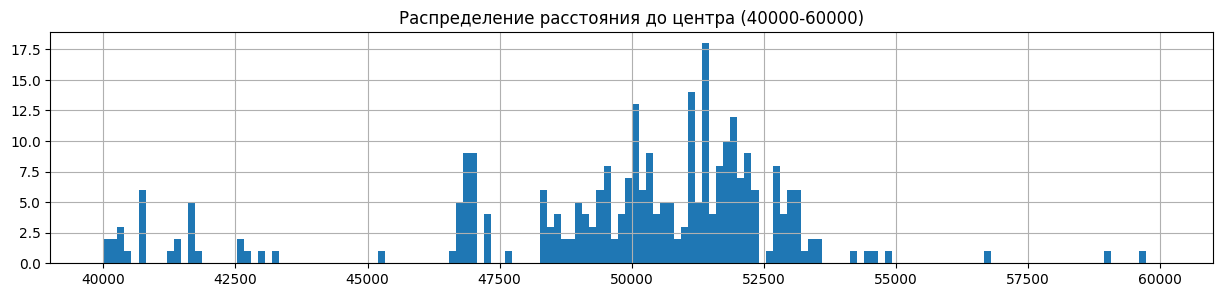

In [92]:
df['cityCenters_nearest'].hist(bins=150, figsize=(15, 3), range=(40000, 60000))
plt.title('Распределение расстояния до центра (40000-60000)');

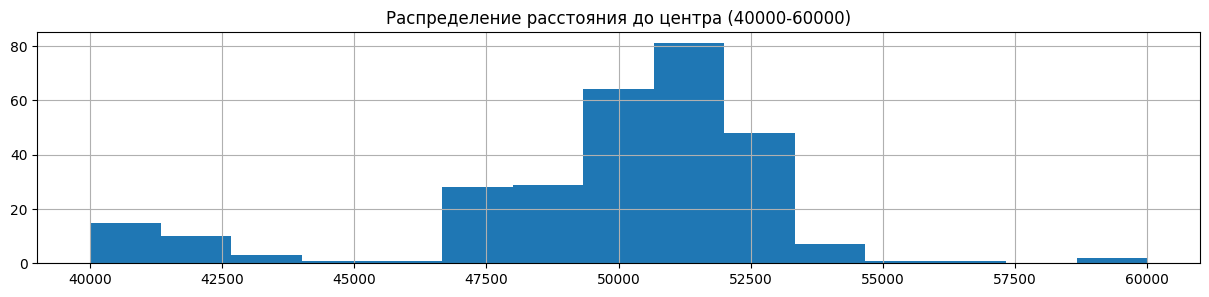

In [93]:
df['cityCenters_nearest'].hist(bins=15, figsize=(15, 3), range=(40000, 60000))
plt.title('Распределение расстояния до центра (40000-60000)');

In [94]:
(
   100 - good_df.loc[(good_df['cityCenters_nearest'].isna()) | 
                ((good_df['cityCenters_nearest'] <= 55000) &
               (good_df['cityCenters_nearest'] >= 1000))].shape[0] / good_df.shape[0] * 100
)

0.34316784027096503

In [95]:
good_df = (
    good_df.loc[(good_df['cityCenters_nearest'].isna()) | 
                ((good_df['cityCenters_nearest'] <= 55000) &
               (good_df['cityCenters_nearest'] >= 1000))]
)

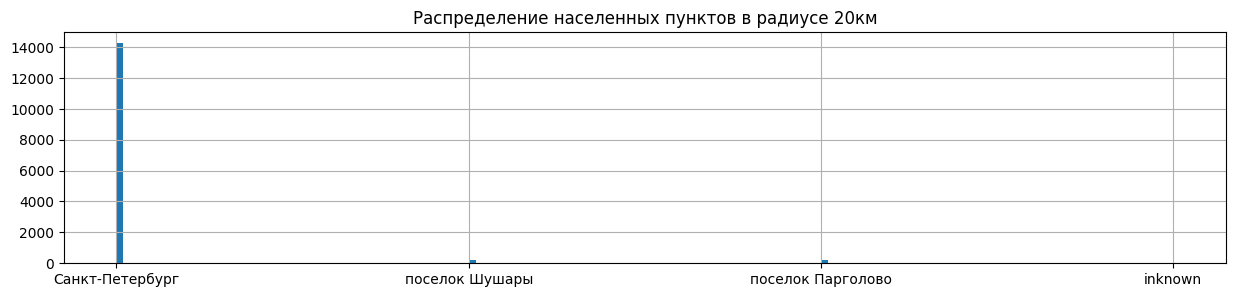

In [96]:
good_df.query('cityCenters_nearest < 20000')['locality_name'].hist(bins=150, figsize=(15, 3))
plt.title('Распределение населенных пунктов в радиусе 20км');

Имеются 2 пика примено на 5000 и на 15000. Основное распределение лежит в диапазоне от 1000 до 40000 (можно было предположить, что 2 пик характерен для поселков, но нет)

Изучим расстояние до ближайшего парка

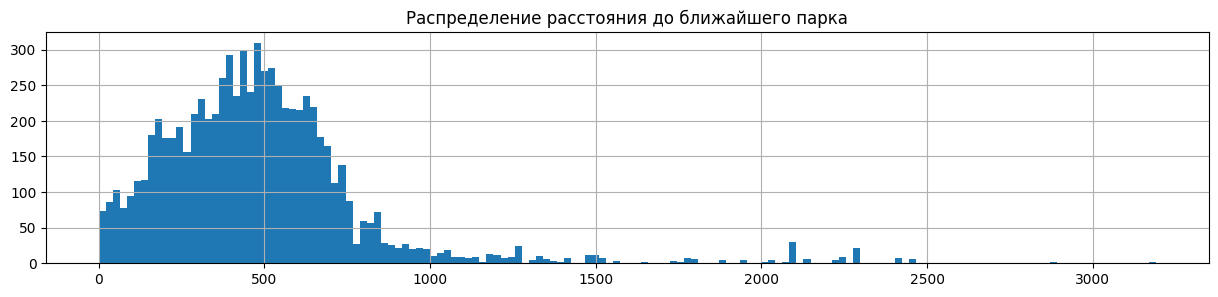

In [97]:
good_df['parks_nearest'].hist(bins=150, figsize=(15, 3))
plt.title('Распределение расстояния до ближайшего парка');

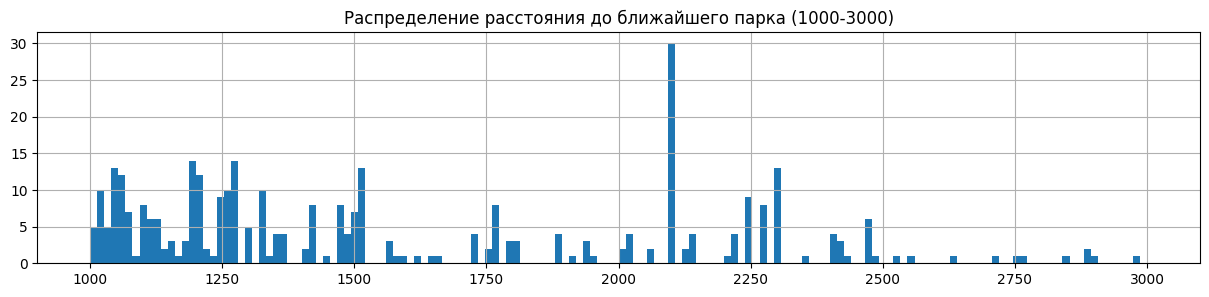

In [98]:
good_df['parks_nearest'].hist(bins=150, figsize=(15, 3), range=(1000, 3000))
plt.title('Распределение расстояния до ближайшего парка (1000-3000)');

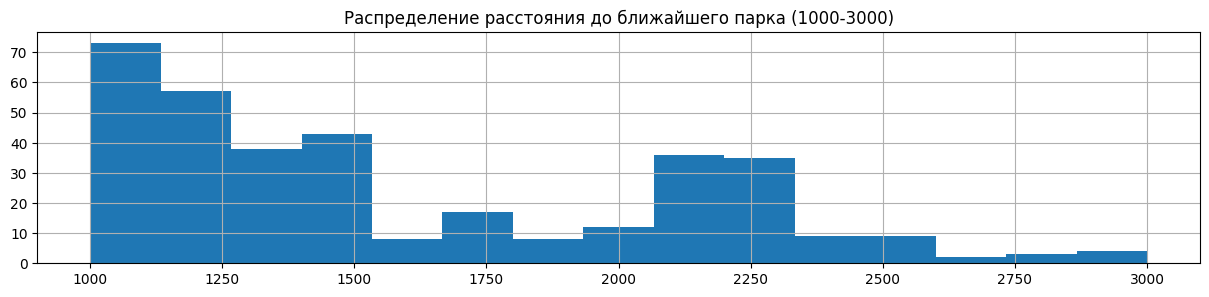

In [99]:
good_df['parks_nearest'].hist(bins=15, figsize=(15, 3), range=(1000, 3000))
plt.title('Распределение расстояния до ближайшего парка (1000-3000)');

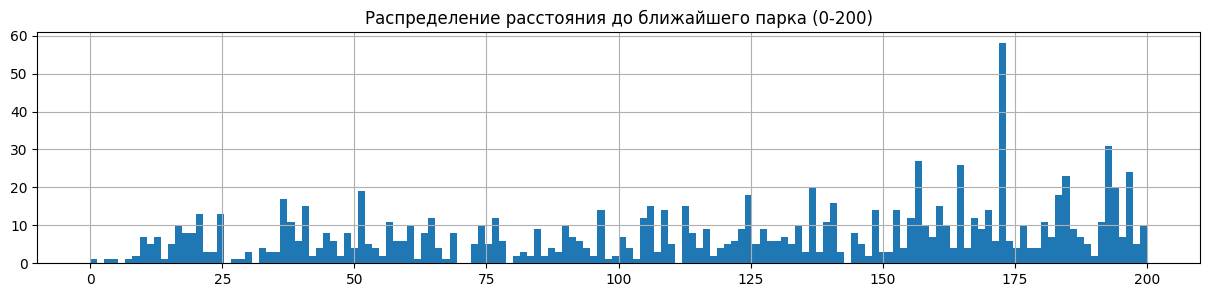

In [100]:
good_df['parks_nearest'].hist(bins=150, figsize=(15, 3), range=(0, 200))
plt.title('Распределение расстояния до ближайшего парка (0-200)');

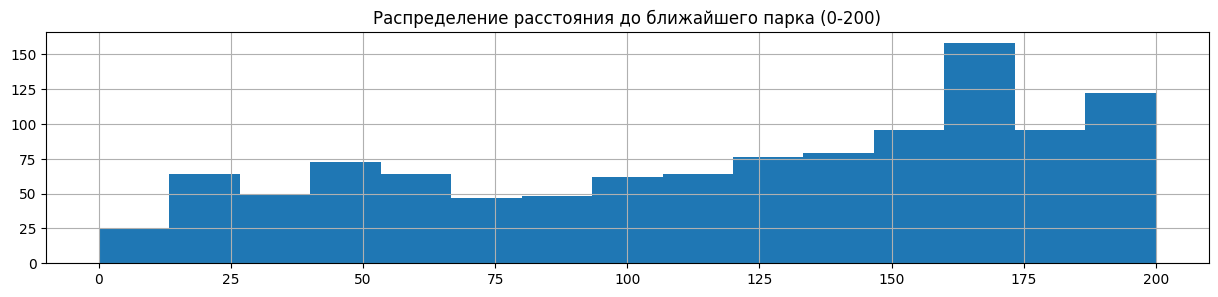

In [101]:
good_df['parks_nearest'].hist(bins=15, figsize=(15, 3), range=(0, 200))
plt.title('Распределение расстояния до ближайшего парка (0-200)');

In [102]:
good_df.loc[df['parks_nearest'] < 50].shape[0] / good_df.shape[0] * 100

0.818389159697688

In [103]:
good_df = good_df.loc[(df['parks_nearest'].isna()) | (df['parks_nearest'] >= 50)]

Основное распределение лежит в диапазоне от 50 до 1000 м. то. Хвост начинается с 1500 м, но так как дальше нам потребуются эти данные, оставим их. Пик находится примерно на 500м.

Посчитаем сколько данных мы потеряли после фильтрации данных

In [104]:
round(100 - good_df.shape[0] / 23699 * 100, 2)

6.42

In [105]:
good_df.shape[0]

22178

**Вывод:**

`total_area` - Основное распределение лежит в диапазоне от 20 до 250, все остальное посчитали редкостями, пик находится примерно в диапазоне 45-60

`living_area` - Пиковое значение находится примерно в диапазоне от 17 до 20, дальше идет резкий провал в диапазоне от 21 до 26, снова пик, но меньше примерно в 2 раза, дальше идет уменьшение с длинным хвостом. Значения меньше 12 и больше 125 удалены.

`kitchen_area` - Пик находится примерно в диапазоне от 5 до 17. Все значения меньше 4 и больше 40 удалены, так как эти значения очень редкие. Большинство кухонь укладывается в диапазон 5-20 кв.м

`last_price` - Основное распределение в диапазоне от 1 до 40млн, по обе стороны хвосты, которые были удалены. Пик значений примерно в диапазоне от 2.5 до 5млн

`rooms` - Типовое количество комнат 1, 2, 3. Квартиры с количеством комнат больше 5 удалены

`categorize_floor` - Большинство квартир находится между первым и последним этажем

`ceiling_height` - Основное распределение находится в диапазоне от 2.5 до 4 м. Остальное посчитали редкостями и удалили.
Так же были значения, такие как 25, 27, 32 скорее всего это ошибка ввода, поэтому эти значения были поделены на 10.

`floors_total` - Типовая этажность - 5 этажей и 9 этажей. Значения меньше 2 и больше 30 посчитали редкостями

`citynearest` - Имеются 2 пика примено на 5000 и на 15000. Основное распределение лежит в диапазоне от 1000 до 40000 (можно было предположить, что 2 пик характерен для поселков, но оказалось, что нет)

`park_nearest` - Основное распределение лежит в диапазоне от 50 до 1000 м. Хвост начинается с 1500 м, но так как дальше нам потребуются эти данные, оставим их. Пик находится примерно на 500м.

Потеря данных составила 6.42%

#### Изучим, как быстро продавались квартиры

In [106]:
good_df['days_exposition'].describe()

count    19243.000000
mean       179.460687
std        217.829074
min          2.000000
25%         45.000000
50%         95.000000
75%        229.000000
max       1580.000000
Name: days_exposition, dtype: float64

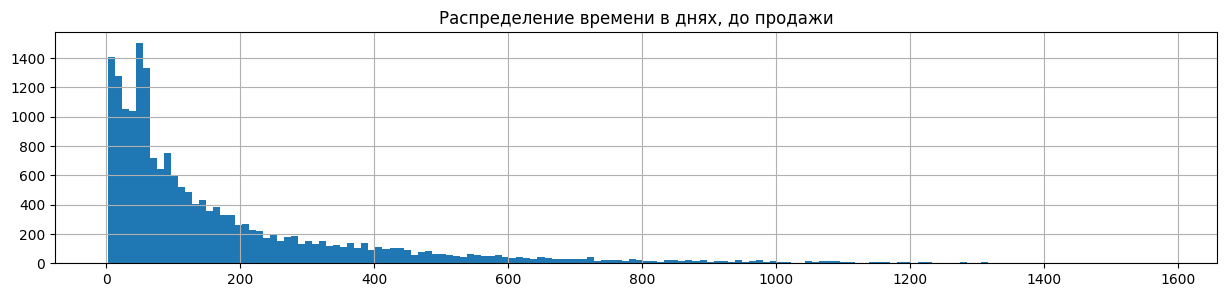

In [107]:
good_df['days_exposition'].hist(bins=150, figsize=(15,3))
plt.title('Распределение времени в днях, до продажи');

Распределение Пуассона, на гистограмме видно, что некоторые объявления висят даже по 4 года

Найдем среднее, медиану и моду

In [108]:
good_df['days_exposition'].mean().round(2)

np.float64(179.46)

In [109]:
good_df['days_exposition'].median()

np.float64(95.0)

In [110]:
good_df['days_exposition'].mode()

0    45.0
Name: days_exposition, dtype: float64

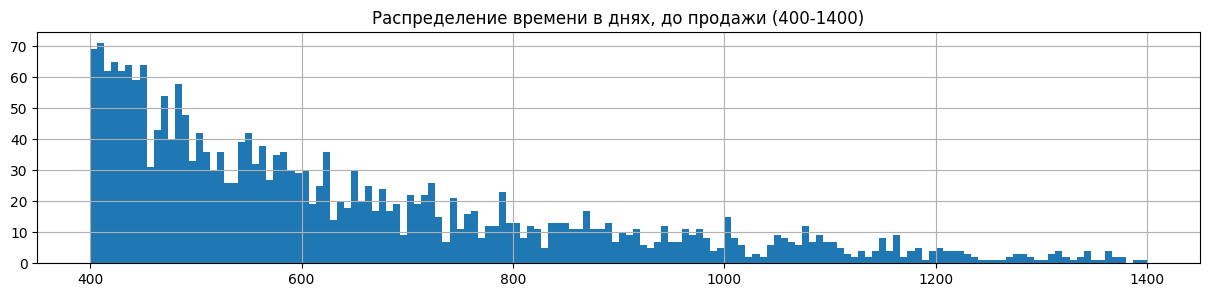

In [111]:
good_df['days_exposition'].hist(bins=150, figsize=(15,3), range=(400, 1400))
plt.title('Распределение времени в днях, до продажи (400-1400)');

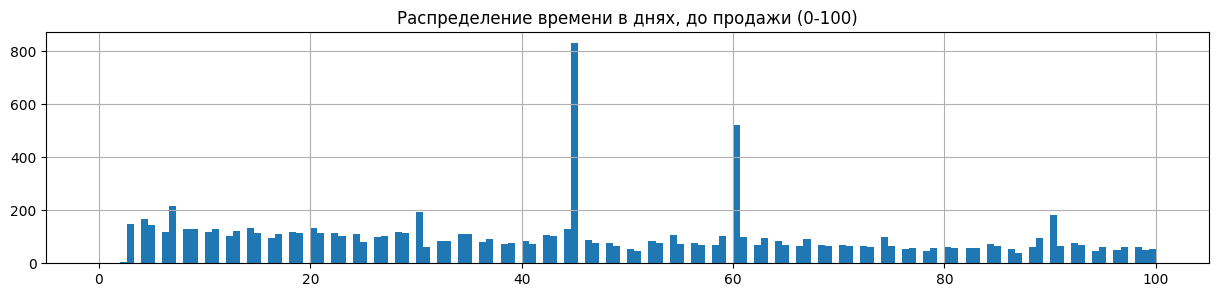

In [112]:
good_df['days_exposition'].hist(bins=150, figsize=(15,3), range=(0, 100))
plt.title('Распределение времени в днях, до продажи (0-100)');

Удалим редкие значения ниже 3 и выше 1050

In [113]:
(
    100 - good_df.loc[(good_df['days_exposition']).isna() |
                      ((good_df['days_exposition'] >= 3) &
                       (good_df['days_exposition'] <= 1050))].shape[0] / good_df.shape[0] * 100
)

0.9288484083325841

In [114]:
good_df = (
        good_df.loc[(good_df['days_exposition']).isna() |
                      ((good_df['days_exposition'] >= 3) &
                       (good_df['days_exposition'] <= 1050))]
)

In [115]:
good_df.shape[0]

21972

In [116]:
good_df['days_exposition'].describe()

count    19037.000000
mean       168.625151
std        191.341511
min          3.000000
25%         44.000000
50%         93.000000
75%        221.000000
max       1050.000000
Name: days_exposition, dtype: float64

Будем считать что, слишком быстрые продажи меньше 44 дней, а слишком быстрые больше 221 дня

In [117]:
good_df['locality_name'].value_counts()

locality_name
Санкт-Петербург           14509
поселок Мурино              503
Кудрово                     438
поселок Шушары              423
Всеволожск                  378
                          ...  
поселок Володарское           1
деревня Нижняя                1
деревня Тихковицы             1
деревня Борисова Грива        1
поселок Дзержинского          1
Name: count, Length: 314, dtype: int64

Больше всего продавались квартиры в городе Санкт-Петербург

Посмотрим на распределение в Санкт-Петербурге

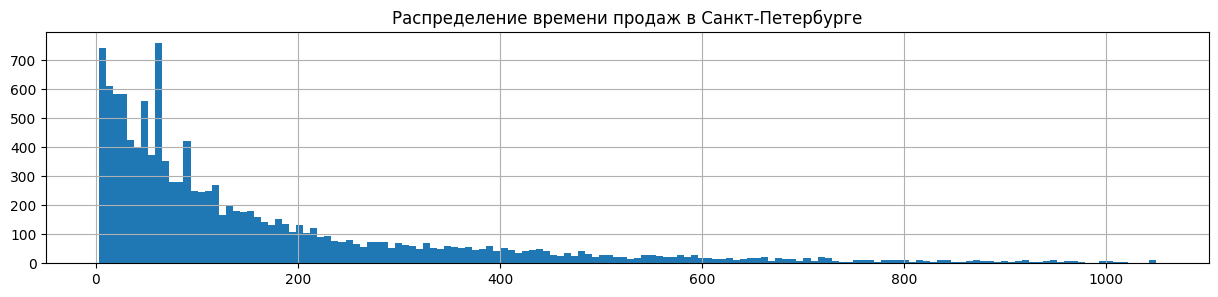

In [118]:
good_df.query('locality_name == "Санкт-Петербург"')['days_exposition'].hist(bins=150, figsize=(15,3))
plt.title('Распределение времени продаж в Санкт-Петербурге');

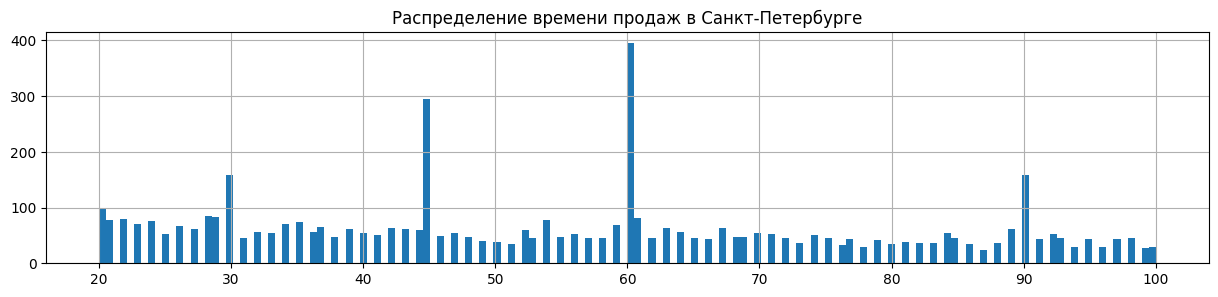

In [119]:
good_df.query('locality_name == "Санкт-Петербург"')['days_exposition'].hist(bins=150, figsize=(15,3), range=(20, 100))
plt.title('Распределение времени продаж в Санкт-Петербурге');

В Санкт-Петербурге мода 60, следующее частовстречаемое значение 45

Посмотрим на распредление всех остальных мест

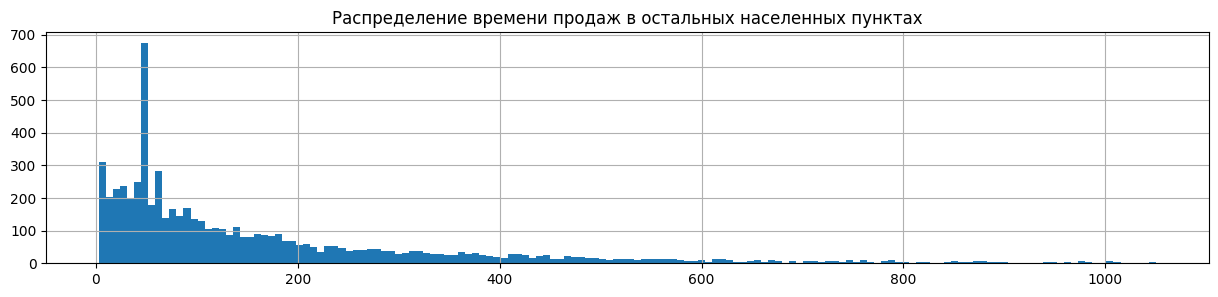

In [120]:
good_df.query('locality_name != "Санкт-Петербург"')['days_exposition'].hist(bins=150, figsize=(15, 3))
plt.title('Распределение времени продаж в остальных населенных пунктах');

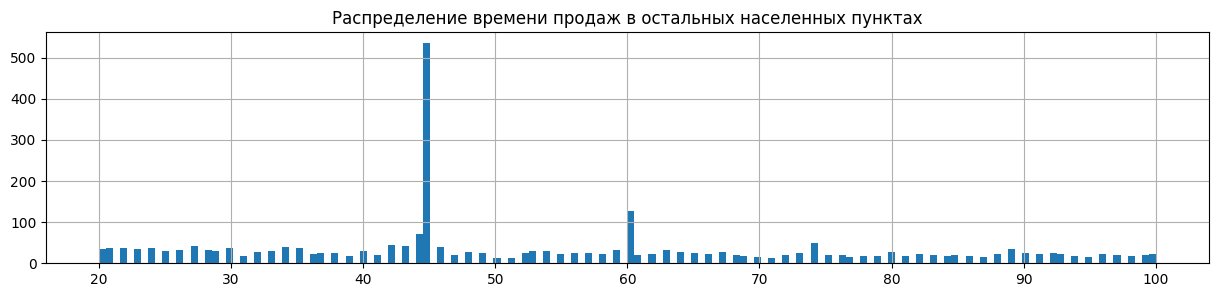

In [121]:
good_df.query('locality_name != "Санкт-Петербург"')['days_exposition'].hist(bins=150, figsize=(15, 3), range=(20, 100))
plt.title('Распределение времени продаж в остальных населенных пунктах');

In [122]:
good_df.query('locality_name != "Санкт-Петербург"')['days_exposition'].mode()

0    45.0
Name: days_exposition, dtype: float64

В населенных пунктах кроме Санкт-Петербурга сильно выделяется значение 45. В яндекс недвижимости срок публикации как раз таки составляет 45 дней. Поэтому объявление не дожидается продажи, а просто удаляется из публикаций

In [123]:
good_df.query('locality_name == "Санкт-Петербург"')['days_exposition'].mean().round()

np.float64(168.0)

In [124]:
good_df.query('locality_name != "Санкт-Петербург"')['days_exposition'].mean().round()

np.float64(170.0)

Среднее время продаж в Санкт-Петербурге и других населенных пунктах практически одинаково 168-170 дней

Посмотрим на скорость продаж по годам

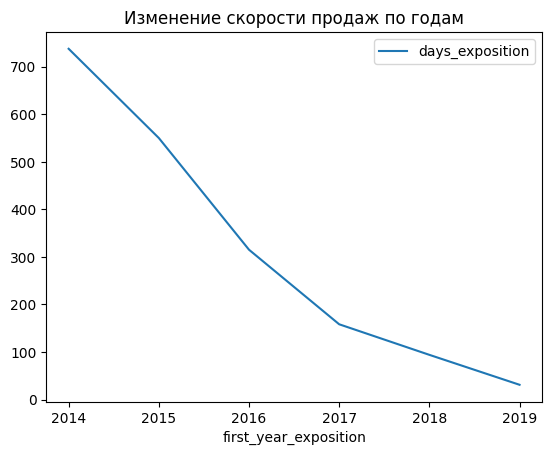

In [125]:
good_df.pivot_table(index='first_year_exposition', values='days_exposition') \
.plot(kind='line', title='Изменение скорости продаж по годам');

С каждым годом скорость продаж увеличивается

#### Определим факторы, которые больше всего влияют на общую (полную) стоимость объекта

Зависимость цены от общей площади

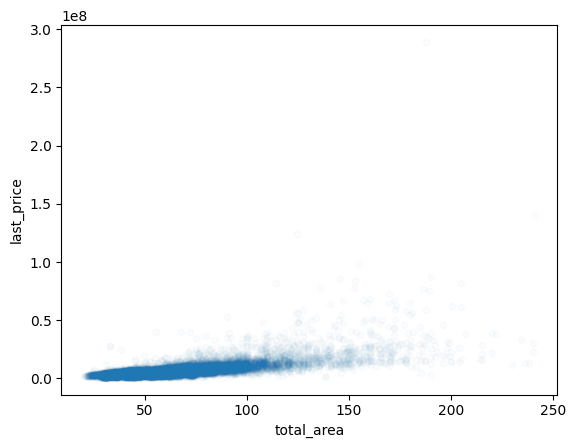

In [126]:
good_df.plot(x='total_area', y='last_price', kind='scatter', alpha=0.02);

In [127]:
round(good_df['last_price'].corr(good_df['total_area']),2)

np.float64(0.69)

Примерно до длощади 125 хорошо прослеживатеся зависимость, а потом точки идут в разнобой, в целом корреляция хорошая 0.79

Зависимость цены от жилой площади

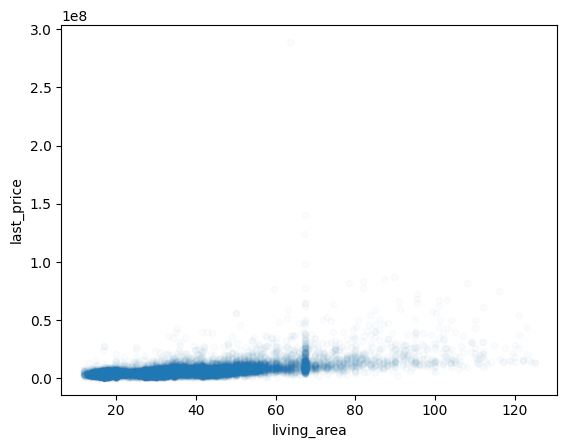

In [128]:
good_df.plot(x='living_area', y='last_price', kind='scatter', alpha=0.02);

In [129]:
round(good_df['last_price'].corr(good_df['living_area']), 2)

np.float64(0.58)

Зависимость цены от площади кухонь

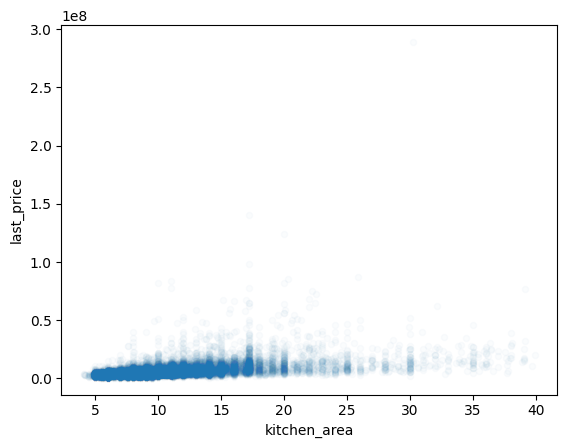

In [130]:
good_df.plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.02);

In [131]:
round(good_df['last_price'].corr(good_df['kitchen_area']), 2)

np.float64(0.5)

Зависимость цены от количества комнат

Сделаем сводную таблицу с медианным значением цены по количеству комнат

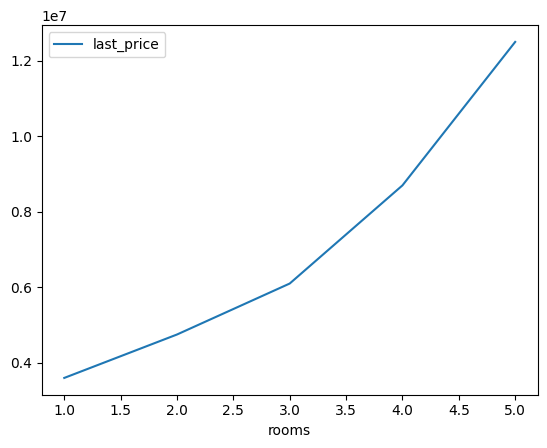

In [132]:
good_df.pivot_table(index='rooms', values='last_price', aggfunc='median') \
        .plot(kind='line');

Тут все понятно, чем больше комнаты тем, выше цена квартиры

Зависимость цены от типа этажа

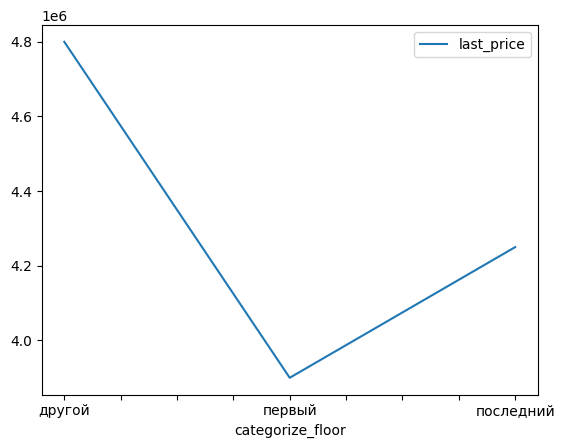

In [133]:
good_df.pivot_table(index='categorize_floor', values='last_price', aggfunc='median') \
        .plot(kind='line');

Что можно сказать по графику самые большие цены для квартир которые относятся к категории `другой`, зависимость тут никак не построишь

Зависимость цены от даты размещения 

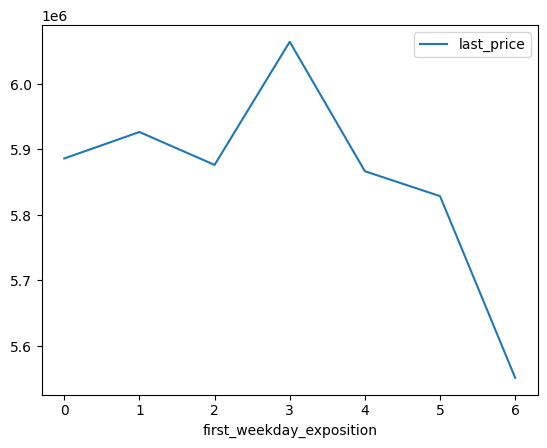

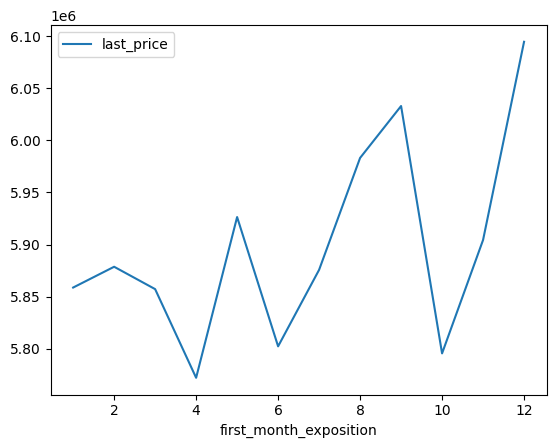

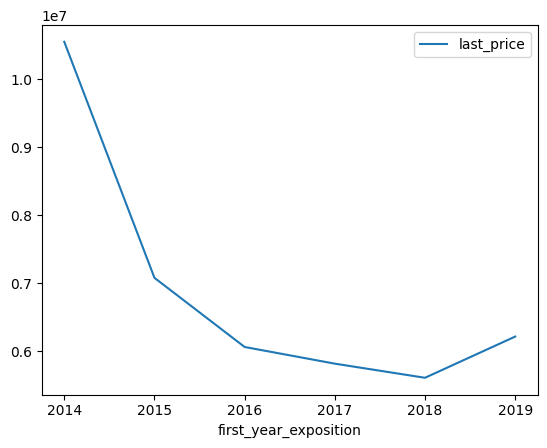

In [134]:
for i in ['first_weekday_exposition', 'first_month_exposition', 'first_year_exposition']:
    good_df.pivot_table(index=i, values='last_price') \
        .plot(kind='line')

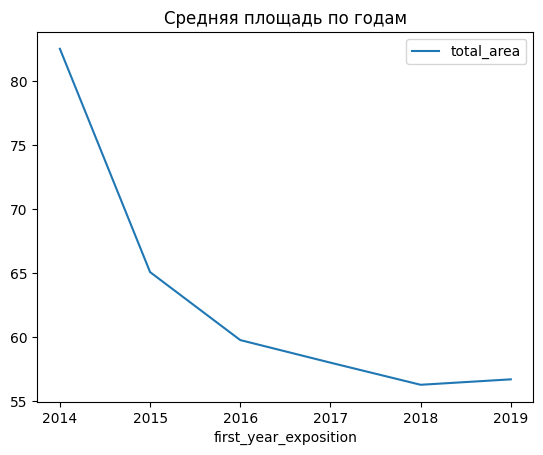

In [135]:
good_df \
    .pivot_table(index='first_year_exposition', values='total_area') \
    .plot(kind='line', title='Средняя площадь по годам');

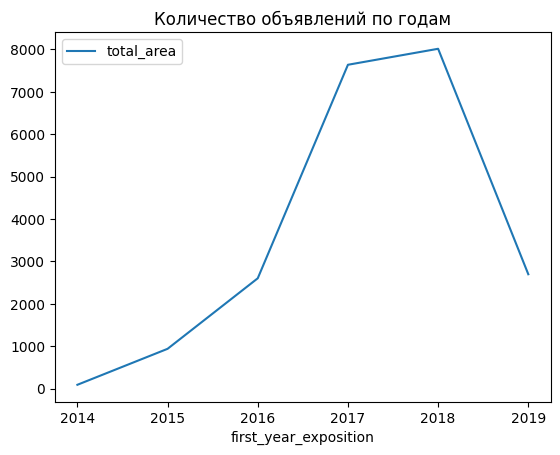

In [136]:
good_df \
    .pivot_table(index='first_year_exposition', values='total_area', aggfunc='count') \
    .plot(kind='line', title='Количество объявлений по годам');

Цены на квартиры с годами падали, из-за того что площадь выставляемых квартир была меньше с каждым годом, также наблюдался рост количества объявлений, поэтому средняя цена и площадь становились меньше

**Основные факторы влияющие на цену недвижимости:**
- Общая площадь (коэффициент корреляции равен 0.69)
- Жилая площадь (коэффициент корреляции равен 0.58)
- Площадь кухонь (коэффициент корреляции равен 0.5)
- Количество комнат (чем больше, тем дороже)
- Год размещения объявления о продаже недвижимость (с 2014 года цены уменьшались, с 2018 начался рост)
- Средняя площадь квартир уменьшалась, за счет того что выросло число объявлений

#### Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [137]:
df_mean_price_square = good_df.pivot_table(index='locality_name', values='one_square_m_price', aggfunc=['count', 'mean'])
df_mean_price_square.columns = ['count', 'mean']
top_10 = df_mean_price_square.sort_values('count', ascending=False).head(10).sort_values('mean', ascending=False).round(2)
top_10

,count,mean
locality_name,,
Санкт-Петербург,14509,112260.86
Пушкин,335,103037.18
Кудрово,438,95122.57
поселок Парголово,310,90281.17
поселок Мурино,503,84860.60
поселок Шушары,423,77854.45
Колпино,330,75198.13
Гатчина,278,68935.71
Всеволожск,378,68754.73


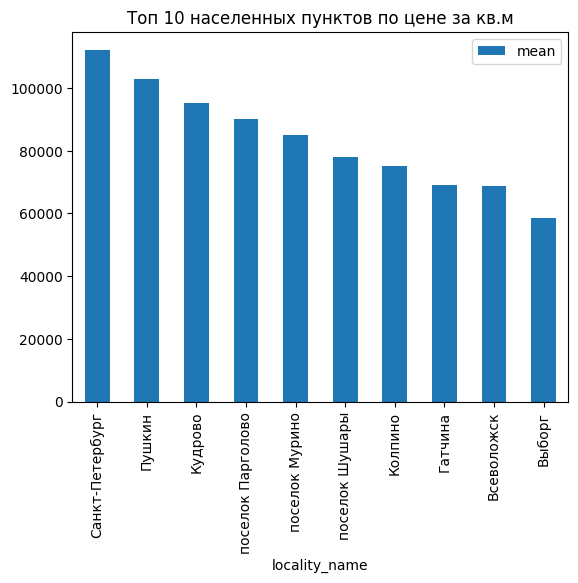

In [138]:
top_10.plot(y='mean', kind='bar', title='Топ 10 населенных пунктов по цене за кв.м');

Максимальная цена 1 квадратного метра в:

In [139]:
top_10['mean'].idxmax()

'Санкт-Петербург'

Минимальная цена 1 квадратного метра в:

In [140]:
top_10['mean'].idxmin()

'Выборг'

#### Выделим квартиры в Санкт-Петербурге и вычислим их среднюю стоимость на разном удалении от центра

Text(0.5, 1.0, 'Зависимость цены от расстояния до центра')

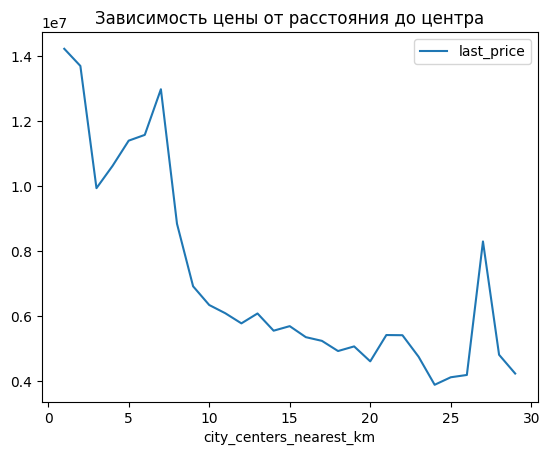

In [141]:
good_df.query('locality_name == "Санкт-Петербург"') \
        .pivot_table(index='city_centers_nearest_km', values='last_price') \
        .plot(kind='line')
plt.title('Зависимость цены от расстояния до центра')

По тренду видно, что чем дальше квартира от центра тем она дешевле

In [142]:
data = good_df.groupby(['categorize_floor', 'city_centers_nearest_km']) \
    .agg('count')['total_area'] \
    .to_frame() \
    .reset_index() \
    .rename(columns={'total_area': 'count'}) \
    .sort_values('city_centers_nearest_km')

In [143]:
data['part'] = data['count']

In [144]:
for km in data['city_centers_nearest_km']:
    data.loc[data['city_centers_nearest_km'] == km, 'part'] = ( 
        data.loc[data['city_centers_nearest_km'] == km, 'count'] /
        data.query('city_centers_nearest_km == @km')['count'].sum()
    ) 

C:\Users\99893\AppData\Local\Temp\ipykernel_1484\2458064740.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.66363636 0.10909091 0.22727273]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['city_centers_nearest_km'] == km, 'part'] = (


In [145]:
data.head()

,categorize_floor,city_centers_nearest_km,count,part
0,другой,1.0,73,0.663636
49,первый,1.0,12,0.109091
99,последний,1.0,25,0.227273
50,первый,2.0,40,0.156250
100,последний,2.0,65,0.253906


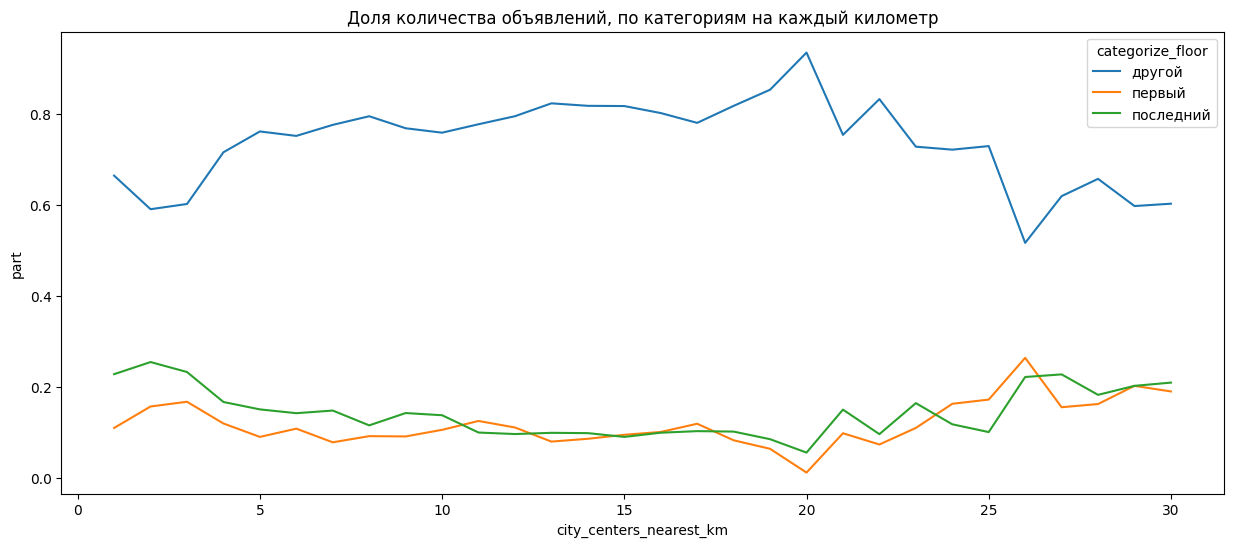

In [146]:
plt.figure(figsize=(15,6))
sns.lineplot(data=data.query('city_centers_nearest_km < 31'), x='city_centers_nearest_km', y='part', hue='categorize_floor');
plt.title('Доля количества объявлений, по категориям на каждый километр');

**Общая потеря данных**

In [147]:
round(100 - good_df.shape[0] / 23699 * 100, 2)

7.29

**Вывод:** 

**Как быстро продавались квартиры**

Половина всех объявлений закрывались чем за 95 дней. Слишком быстрые продажи меньше 44 дней, а слишком быстрые больше 221 дня. Средняя скорость продаж 168-170. С каждым годом продажи были все быстрее, также это связано с тем, что с каждым годом цена на квартиры уменьшалась. Мода для Санкт-Петербурга 60, для остальных населенных пунктов 45 (что соответствует минимальному времени публикации квартиры до 4.5 млн)

Из **10 населенных пунктов с наибольшим количеством объявлений** максимальное цена за квадратный метр в Санкт-Петербурге,
минимальная цена в Выборге

В Санкт-Петерберге, чем дальше объект находится от центра города, тем дешевле его стоимость

### Напишите общий вывод

#### Предобработка данных

Были выявлены следующие проблемы:
- Пропуски
    - Пропуски в столбцах `as_apartment`, `balcony`, были в связи с тем, что квартира не являлась апартаментами и не было балкона соответственно (заполнены False, 0). 

    - Столбец `locality_name` с названиями местностей, пропуски заменены на _'unknown'_. 

    - Пропуски в столбцах `ponds_around3000`, `parks_around3000` означали, что в радиусе 3000 метром нет парка или пруда заполнены _нулями_. 
    
    - Пропуски `floors_total` удалены их было всего 86
    
    - `total_area` было разбито на 6 категорий (диапазонов) с помощью метода qcut, пропуски заполнены средним значение `living_area` и `kitchen_area` по соответствующим категориям

    - В столбце `ceiling_height` пропуски заполнены средним значением по населенным пунктам, значениея 25, 32, 27 поделены на 10, так как скорее всего представляют ошибку ввода

    - Остальные пропуски оставлены как есть, в связи с тем, что ничем не заменишь их иначе они исказят дальнейшие вычисления
- Неправильный тип данных
    - `first_day_exposition` имел тип _object_, заменен на _datetime_.
    - `balcony`, `ponds_around3000`, `parks_around3000`, `floors_total` преобразованы из типа _float_ в тип _int_
- Неявные дубликаты
    - Одинаковые значения записанные по разному были переименованы с помощью метода _str.replace_
    - деревня Кудрово, на данный момент является городом Кудрово, переименовали про как Кудрово
- Явные дубликаты
    - По основным признакам выявлено 209 явных дубликатов (`total_area, rooms, floor, floors_total', cityCenters_nearest, locality_name`)
    
Общая потеря данных в процессе обработки составляет **7.29%**

#### Цели проекта

**Целью проекта - является определение факторов, которые влияют на цену недвижимости**

Факторы влияющие на цену объекта:
- Общая площадь (коэффициент корреляции равен 0.69)
- Жилая площадь (коэффициент корреляции равен 0.58)
- Площадь кухонь (коэффициент корреляции равен 0.5) т.е в целом чем больше любая из площадей, тем дороже объект
- Количество комнат (чем больше, тем дороже)
- Год размещения объявления о продаже недвижимость (с 2014 года цены уменьшались, с 2018 начался рост)
- Цена за квадратный метр в Санкт-Петербурге самая высокая (111539 руб.) по сравнению с населенными пунктами рядом, минимальная цена в населенном пункте 'Выборг' (58190 руб.)
- Цена объкта также зависит от расстояния объекта до центра города (чем дальше, тем дешевле)

С каждым годом цена на квартиры падала, это связано с тем, что средняя площадь продаваемых квартир уменьшалась, за счет роста количеста объявлений ведь основная часть квартир приходится на площадь примерно от 20 до 100 кв.м. Так же за счет этого с каждым годом дополнительно увеличилась средняя скорость продаж квартир (более дешевые квартиры может позволить себе большее число граждан)